# Datengetriebene Analyse zur Optimierung von Airbnb-Investitionen in Zürich für "InvestZurich AG"

**Kontext:**
Dieser Report wurden im Rahmen des MSc in Wirtschaftsinformatik (BFH-OST-HSLU-FFHS) im Zuge des BINA-Moduls (Business Intelligence & Business Analytics) im Frühlingssemester 2025 erstellt. Die Fallstudie wurde als Gruppenarbeit erarbeitet und stellt einen Teil des Modul-Kompetenznachweises dar.

**Autoren:**
- Bielmann Tobias (BFH)
- Hösli Marc (BFH)
- Künzli Joel (BFH)
- Mühlemann Robin (BFH)
- Sinzig Basil (BFH)

**Datum:**
2. Juni 2025

**Einleitung:**
Die vorliegende Fallstudie untersucht den Airbnb-Markt der Stadt Zürich, zur Optimierung von Investitionsstrategien, für unsere hypothetische Investorenfirma "InvestZurich AG". In einem zunehmend wettbewerbsintensiven Umfeld für Kurzzeitvermietungen ist es für Investoren entscheidend, datengestützte Entscheidungen zu treffen, um die Rentabilität zu maximieren und Risiken zu minimieren. Dieses Projekt zielt darauf ab, die Prinzipien des Data-Driven Decision Making (DDDM) und die im Modul BINA erlernten Analysemethoden anzuwenden, um InvestZurich AG bei der Beantwortung zentraler Fragen in Bezug auf Marktpotenzial, Preisgestaltung, Wettbewerbsanalyse und Performance-Optimierung in Zürich zu helfen.

Die Vorgehensweise folgt dem von CPA Canada entwickelten Framework „From Data to Decisions“, das datenbasierte Entscheidungsprozesse in fünf aufeinander aufbauenden Schritten strukturiert. In dieser Arbeit werden die Schritte 1 bis 4 detailliert adressiert und ein Ausblick auf Schritt 5 gegeben.

## 1. Defining Objectives and Information Needs

In diesem ersten Schritt definieren wir die übergeordneten Ziele des Projekts und den damit verbundenen Informationsbedarf. Für die "InvestZurich AG" wurden vier zentrale Use Cases identifiziert.

### Use Case 1: Marktpotenzial & Standortanalyse
* **Ziel:** Identifizierung der attraktivsten Standorte und Objektarten für Airbnb-Investitionen in Zürich.
* **Schlüsselfragen:** Angebotsdichte, Durchschnittspreise, Nachfrageindikatoren und Einfluss von Unterkunftstyp/Kapazität pro Standort.

### Use Case 2: Preisstrategie & Ertragsprognose
* **Ziel:** Verständnis der Haupttreiber für Airbnb-Preise in Zürich und Schaffung einer Basis für Preisprognosen.
* **Schlüsselfragen:** Quantitativer Einfluss von Objektmerkmalen auf den Preis.

### Use Case 3: Performance Optimierung & Benchmarking
* **Ziel:** Ermittlung der Erfolgsfaktoren von Top-Performern (insbesondere Superhosts) und Ableitung von Handlungsempfehlungen.
* **Schlüsselfragen:** Unterschiede zwischen Superhosts und anderen; Prädiktoren für Superhost-Status.

### Use Case 4: Listing-Optimierung durch Textanalyse
* **Ziel:** Untersuchung, ob und wie der Inhalt und Tonfall von Beschreibungstexten mit der Performance der Listings korrelieren.
* **Schlüsselfragen:** Einfluss von Sentiment und thematischem Inhalt auf Bewertungen/Preise; Optimierungsempfehlungen für Listing-Texte.

## 2. Collecting Data

### 2.1 Datenquellen und -beschaffung via Supabase

Die für diese Analyse verwendeten Datensätze wurden ursprünglich von [Inside Airbnb](http://insideairbnb.com/get-the-data/#Zurich) (Datenstand ca. 23. März 2025) und [Stadt Zürich Open Data](https://data.stadt-zuerich.ch/dataset/bau_hae_preis_stockwerkeigentum_zimmerzahl_stadtquartier_od5155) (Datenstand ca. 20. Januar 2025) bezogen.

Diese Rohdaten wurden bereits in eine Supabase-Datenbank geladen und dort in den Tabellen `cleaned_listings` und `cleaned_selling_prices` zentral bereinigt und aufbereitet. Die Spaltennamen und Datentypen in diesen Supabase-Tabellen entsprechen den Definitionen in `bina_models.py`.

**In Supabase durchgeführte Aufbereitungsschritte umfassen:**
* **Schema-Validierung und -Anpassung:** Sicherstellung, dass die Datenstruktur den `Listing`- und `SellingPrices`-Modellen entspricht
* **Behandlung von Duplikaten.**
* **Standardisierung von Formaten** (Datum, Boolean)
* **Parsing komplexer Felder** (Preis-Strings zu numerischen Werten, initiale Textverarbeitung). Für `amenities` wurde sichergestellt, dass es als Liste von Strings geladen wird. `bathrooms` wurde als numerischer Wert (`float`) etabliert
* **Umgang mit fehlenden Werten (initial)**
* **Typkonvertierungen** gemäss `bina_models.py`

Für diese Analyse greifen wir über den benutzerdefinierten Python-Service `AirbnbAnalysisService` auf diese bereits in Supabase aufbereiteten Tabellen zu.

In [7]:
# === Bibliotheken importieren ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import nltk
import dataclasses

# NLTK Ressourcen (Downloads)
nltk_resources = ['wordnet', 'stopwords', 'punkt', 'omw-1.4']
for resource in nltk_resources:
    try:
        resource_path_part = f'corpora/{resource}.zip' if resource in ['wordnet', 'stopwords', 'omw-1.4'] else f'tokenizers/{resource}.zip'
        nltk.data.find(resource_path_part)
        print(f"NLTK Ressource '{resource}' bereits vorhanden.")
    except LookupError: # Korrektes Abfangen von LookupError
        print(f"NLTK Ressource '{resource}' nicht gefunden. Versuche Download...")
        try:
            nltk.download(resource, quiet=False)
            print(f"NLTK Ressource '{resource}' erfolgreich heruntergeladen.")
        except Exception as e: # Allgemeiner Fehler beim Download
            print(f"Fehler beim Herunterladen von '{resource}': {e}. Bitte manuell prüfen mit nltk.download('{resource}').")

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score,
    mean_squared_error, r2_score
)
from sklearn.impute import SimpleImputer

# Importiere den Service und die Modelle
# Stelle sicher, dass airbnb_analysis_service.py und bina_models.py im selben Verzeichnis oder im Python-Pfad sind.
try:
    from airbnb_analysis_service import AirbnbAnalysisService
    from bina_models import Listing, SellingPrices
except ImportError as e:
    print(f"Fehler beim Importieren des Services oder der Modelle: {e}")
    AirbnbAnalysisService = None; Listing = None; SellingPrices = None

# Plotting-Einstellungen
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")
# %matplotlib inline # Zeile für Jupyter Notebooks, um Plots inline anzuzeigen (kann hier auskommentiert bleiben)

# === Daten laden via Service ===
listings_df = pd.DataFrame() # Wird direkt mit den Daten aus dem Service befüllt
selling_prices_df = pd.DataFrame()

if AirbnbAnalysisService:
    try:
        service = AirbnbAnalysisService()
        print("Lade Airbnb Listings via Service (aus Supabase `cleaned_listings`)...")
        listings_objects = service.get_listings()

        if listings_objects and isinstance(listings_objects, list) and len(listings_objects) > 0:
            if hasattr(listings_objects[0], 'model_dump'): listings_data = [l.model_dump(exclude_none=True) for l in listings_objects]
            elif hasattr(listings_objects[0], 'dict'): listings_data = [l.dict(exclude_none=True) for l in listings_objects]
            elif dataclasses.is_dataclass(listings_objects[0]): listings_data = [dataclasses.asdict(l) for l in listings_objects]
            else: listings_data = [l.__dict__ for l in listings_objects]
            listings_df = pd.DataFrame(listings_data) # Direkte Zuweisung zu listings_df
            print(f"Airbnb Listings erfolgreich geladen. Shape: {listings_df.shape}")
        else:
            print("Keine Listings-Daten vom Service erhalten oder Liste ist leer.")

        print("\nLade Immobilien-Verkaufspreise via Service (aus Supabase `cleaned_selling_prices`)...")
        selling_prices_objects = service.get_selling_prices()
        if selling_prices_objects and isinstance(selling_prices_objects, list) and len(selling_prices_objects) > 0:
            if hasattr(selling_prices_objects[0], 'model_dump'): selling_prices_data = [sp.model_dump(exclude_none=True) for sp in selling_prices_objects]
            elif hasattr(selling_prices_objects[0], 'dict'): selling_prices_data = [sp.dict(exclude_none=True) for sp in selling_prices_objects]
            elif dataclasses.is_dataclass(selling_prices_objects[0]): selling_prices_data = [dataclasses.asdict(sp) for sp in selling_prices_objects]
            else: selling_prices_data = [sp.__dict__ for sp in selling_prices_objects]
            selling_prices_df = pd.DataFrame(selling_prices_data) # Direkte Zuweisung zu selling_prices_df
            print(f"Immobilien-Verkaufspreise erfolgreich geladen. Shape: {selling_prices_df.shape}")
        else:
            print("Keine Verkaufspreis-Daten vom Service erhalten oder Liste ist leer.")

    except Exception as e:
        print(f"Fehler beim Laden der Daten via Service: {e}")
else:
    print("AirbnbAnalysisService konnte nicht importiert werden. Daten können nicht geladen werden.")

# === Erste Inspektion der (aus Supabase geladenen) Daten ===
if not listings_df.empty:
    print("\n--- Listings DataFrame (aus Supabase): Erste 5 Zeilen ---"); print(listings_df.head())
    print(f"\n--- Listings DataFrame (aus Supabase): Dimensionen --- \nShape: {listings_df.shape}")
    print("\n--- Listings DataFrame (aus Supabase): Info ---"); listings_df.info()
    print("\n--- Listings DataFrame (aus Supabase): Fehlende Werte (Top 10) ---"); print(listings_df.isnull().sum().sort_values(ascending=False).head(10))
else:
    print("Listings DataFrame ist leer oder konnte nicht geladen werden.")

if not selling_prices_df.empty:
    print("\n\n--- Selling Prices DataFrame (aus Supabase): Erste 5 Zeilen ---"); print(selling_prices_df.head())
    print("\n--- Selling Prices DataFrame (aus Supabase): Info ---"); selling_prices_df.info()
else:
    print("\nSelling Prices DataFrame ist leer oder konnte nicht geladen werden.")

NLTK Ressource 'wordnet' bereits vorhanden.
NLTK Ressource 'stopwords' bereits vorhanden.
NLTK Ressource 'punkt' bereits vorhanden.
NLTK Ressource 'omw-1.4' bereits vorhanden.
Lade Airbnb Listings via Service (aus Supabase `cleaned_listings`)...
Airbnb Listings erfolgreich geladen. Shape: (2036, 71)

Lade Immobilien-Verkaufspreise via Service (aus Supabase `cleaned_selling_prices`)...
Immobilien-Verkaufspreise erfolgreich geladen. Shape: (1670, 18)

--- Listings DataFrame (aus Supabase): Erste 5 Zeilen ---
         id                            listing_url       scrape_id  \
0    178448    https://www.airbnb.com/rooms/178448  20241230011608   
1    227039    https://www.airbnb.com/rooms/227039  20241230011608   
2    310964    https://www.airbnb.com/rooms/310964  20241230011608   
3    577683    https://www.airbnb.com/rooms/577683  20241230011608   
4  14823254  https://www.airbnb.com/rooms/14823254  20241230011608   

  last_scraped       source                                        

**Erste Beobachtungen aus der Dateninspektion (Daten aus Supabase):**

* Das `listings_df` hat **<font color="red">[listings_df.shape[0] einfügen]</font>** Zeilen und **<font color="red">[listings_df.shape[1] einfügen]</font>** Spalten.
* Die Datentypen der Spalten (gemäss `.info()` und Abgleich mit `bina_models.py`):
    * `price` ist vom Typ **<font color="red">[Datentyp von 'price' aus .info()]</font>** (sollte `float64` sein, da `Optional[float]` im Modell).
    * `bathrooms` ist vom Typ **<font color="red">[Datentyp von 'bathrooms' aus .info()]</font>** (sollte `float64` sein).
    * `amenities` ist vom Typ **<font color="red">[Datentyp von 'amenities' aus .info()]</font>** (sollte `object` sein, da es Listen von Strings enthält).
    * `host_is_superhost` ist vom Typ **<font color="red">[Datentyp von 'host_is_superhost' aus .info()]</font>** (sollte `bool` oder `object` (mit `None` als `NaNs`) sein).
    * `host_response_rate` ist **<font color="red">[Datentyp]</font>** (sollte `object` sein, wenn es Strings wie "90%" enthält).
    * `host_acceptance_rate_percent` ist **<font color="red">[Datentyp]</font>** (sollte `int64` oder `float64` sein).
* Möglicherweise verbleibende fehlende Werte nach dem Laden aus Supabase in Spalten wie **<font color="red">[Top 3 Spaltennamen mit vielen NaNs aus listings_df.isnull().sum() eintragen, falls vorhanden]</font>**.
* `selling_prices_df` wurde geladen (Shape: **<font color="red">[selling_prices_df.shape]</font>**). Wichtige Spalten sind `quartierlang`, `raumzhlcode`, `hapreiswohnflaeche`, `hamedianpreis`.

### 2.2 Finale Datenanpassungen und Feature Engineering im Notebook

Obwohl die Daten in Supabase grundlegend bereinigt wurden, führen wir hier finale Anpassungen durch, die spezifisch für die Analysen und Modellierungen in diesem Notebook notwendig sind. Wir erstellen eine Arbeitskopie `df_analysis` von listings_df`.

In [8]:
df_analysis = pd.DataFrame() # Initialisiere df_analysis als leeren DataFrame

if not listings_df.empty:
    df_analysis = listings_df.copy() # Arbeitskopie erstellen

    # 1. Preisspalte ('price') - finale Prüfung und Filterung
    # Annahme: 'price' ist bereits float aus Supabase (gemäss bina_models.Listing.price: Optional[float])
    if 'price' in df_analysis.columns:
        df_analysis['price'] = pd.to_numeric(df_analysis['price'], errors='coerce')
        df_analysis.dropna(subset=['price'], inplace=True)
        if not df_analysis.empty and df_analysis['price'].nunique() > 1 :
            price_q_low_notebook = df_analysis['price'].quantile(0.005)
            price_q_high_notebook = df_analysis['price'].quantile(0.995)
            if pd.notna(price_q_low_notebook) and pd.notna(price_q_high_notebook):
                 df_analysis = df_analysis[df_analysis['price'].between(price_q_low_notebook, price_q_high_notebook, inclusive='both')]
    else:
        print(f"KRITISCH: Preisspalte 'price' fehlt."); df_analysis['price'] = np.nan

    # 2. Numerische Spalten: Finale Imputation für Modellierung
    # 'bathrooms' ist Optional[float]
    # 'beds' ist Optional[float]
    numeric_cols_to_impute_final = [
        'bedrooms', 'bathrooms', 'accommodates', 'beds',
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value', 'reviews_per_month', 'number_of_reviews', 'availability_365',
        'host_listings_count', 'host_total_listings_count'
    ]
    for col in numeric_cols_to_impute_final:
        if col in df_analysis.columns:
            df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
            if df_analysis[col].isnull().sum() > 0:
                if not df_analysis[col].isnull().all():
                    df_analysis[col] = df_analysis[col].fillna(df_analysis[col].median())
                else:
                     df_analysis[col] = df_analysis[col].fillna(0)
        else:
            print(f"Info: Numerische Spalte '{col}' für finale Imputation fehlt."); df_analysis[col] = np.nan

    # 3. Prozentuale Host-Metriken
    # 'host_response_rate': Optional[str] (z.B. "90%")
    if 'host_response_rate' in df_analysis.columns:
        df_analysis['host_response_rate'] = df_analysis['host_response_rate'].replace(['N/A', None, ''], np.nan)
        # Da es als String von Supabase kommen kann (gem. bina_models)
        if df_analysis['host_response_rate'].dropna().apply(lambda x: isinstance(x, str)).any():
             df_analysis['host_response_rate'] = df_analysis['host_response_rate'].str.rstrip('%').astype(float) / 100.0
        else:
            df_analysis['host_response_rate'] = pd.to_numeric(df_analysis['host_response_rate'], errors='coerce')
            mask_hrr_analysis = (df_analysis['host_response_rate'] > 1.0) & (df_analysis['host_response_rate'] <= 100.0)
            df_analysis.loc[mask_hrr_analysis, 'host_response_rate'] = df_analysis.loc[mask_hrr_analysis, 'host_response_rate'] / 100.0

        if not df_analysis['host_response_rate'].isnull().all(): df_analysis['host_response_rate'] = df_analysis['host_response_rate'].fillna(df_analysis['host_response_rate'].median())
        else: df_analysis['host_response_rate'] = df_analysis['host_response_rate'].fillna(0.5)
    else:
        print(f"Info: Spalte 'host_response_rate' fehlt."); df_analysis['host_response_rate'] = np.nan

    # 'host_acceptance_rate_percent': Optional[int] (z.B. 90 für 90%)
    if 'host_acceptance_rate_percent' in df_analysis.columns:
        df_analysis['host_acceptance_rate_percent'] = pd.to_numeric(df_analysis['host_acceptance_rate_percent'], errors='coerce') / 100.0
        if not df_analysis['host_acceptance_rate_percent'].isnull().all(): df_analysis['host_acceptance_rate_percent'] = df_analysis['host_acceptance_rate_percent'].fillna(df_analysis['host_acceptance_rate_percent'].median())
        else: df_analysis['host_acceptance_rate_percent'] = df_analysis['host_acceptance_rate_percent'].fillna(0.5)
    else:
        print(f"Info: Spalte 'host_acceptance_rate_percent' fehlt."); df_analysis['host_acceptance_rate_percent'] = np.nan

    for rate_col in ['host_response_rate', 'host_acceptance_rate_percent']:
        if rate_col in df_analysis.columns: df_analysis[rate_col] = np.clip(df_analysis[rate_col], 0, 1)

    # 4. Amenities ('amenities' ist Optional[list[str]] in bina_models)
    if 'amenities' in df_analysis.columns:
        def count_amenities_from_model_list(amenity_input): # Bereits angepasst für Listen
            if isinstance(amenity_input, list): return len(amenity_input)
            if pd.isna(amenity_input): return 0
            if isinstance(amenity_input, str): # Seltener Fallback für Strings
                 if amenity_input in ['[]', '{}', ''] or not amenity_input.strip(): return 0
                 try:
                     parsed_list = ast.literal_eval(amenity_input)
                     return len(parsed_list) if isinstance(parsed_list, list) else 0
                 except: return 0
            return 0
        df_analysis['num_amenities'] = df_analysis['amenities'].apply(count_amenities_from_model_list)
    else:
        df_analysis['num_amenities'] = 0; print(f"Warnung: Spalte 'amenities' nicht gefunden.")

    # 5. Superhost Status ('host_is_superhost' ist Optional[bool])
    if 'host_is_superhost' in df_analysis.columns:
        df_analysis['host_is_superhost'] = df_analysis['host_is_superhost'].map({True: 1, False: 0}).fillna(0).astype(int)
    else:
        df_analysis['host_is_superhost'] = 0; print(f"Info: Spalte 'host_is_superhost' fehlt, wird mit 0 initialisiert.")

    # 6. Host Response Time ('host_response_time' ist Optional[str])
    if 'host_response_time' in df_analysis.columns:
        df_analysis['host_response_time'] = df_analysis['host_response_time'].fillna('N/A').astype('category')
    else:
        df_analysis['host_response_time'] = 'N/A'; df_analysis['host_response_time'] = df_analysis['host_response_time'].astype('category')

    # 7. Host Identity Verified ('host_identity_verified' ist Optional[bool])
    if 'host_identity_verified' in df_analysis.columns:
        df_analysis['host_identity_verified'] = df_analysis['host_identity_verified'].map({True: 1, False: 0}).fillna(0).astype(int)
    else:
        df_analysis['host_identity_verified'] = 0

    # 8. Standortspalte (`loc_col_for_analysis_notebook`) - Auswahl und Sicherstellung des Typs
    # Definiere eine lokale Variable für die Standortspalte, die in diesem Notebook verwendet wird
    loc_col_for_analysis_notebook = None
    if 'neighbourhood_group_cleansed' in df_analysis.columns and df_analysis['neighbourhood_group_cleansed'].nunique() >= 1:
        loc_col_for_analysis_notebook = 'neighbourhood_group_cleansed'
    elif 'neighbourhood_cleansed' in df_analysis.columns and df_analysis['neighbourhood_cleansed'].nunique() >= 1:
        loc_col_for_analysis_notebook = 'neighbourhood_cleansed'
    elif 'neighbourhood' in df_analysis.columns and df_analysis['neighbourhood'].nunique() >=1:
        loc_col_for_analysis_notebook = 'neighbourhood'

    if loc_col_for_analysis_notebook:
        print(f"Verwende '{loc_col_for_analysis_notebook}' als primäre Standortspalte für Analysen in diesem Notebook.")
        df_analysis[loc_col_for_analysis_notebook] = df_analysis[loc_col_for_analysis_notebook].fillna('Unknown').astype(str)
    else:
        print(f"KRITISCH: Keine valide Standortspalte gefunden. Erstelle 'location_fallback'.");
        df_analysis['location_fallback'] = 'Unknown'; loc_col_for_analysis_notebook = 'location_fallback'
    # Stelle sicher, dass die verwendete Spalte existiert, auch wenn es der Fallback ist
    if loc_col_for_analysis_notebook not in df_analysis.columns: df_analysis[loc_col_for_analysis_notebook] = 'Unknown'
    df_analysis[loc_col_for_analysis_notebook] = df_analysis[loc_col_for_analysis_notebook].astype(str)


    # 9. Room Type ('room_type' ist Optional[str])
    if 'room_type' in df_analysis.columns: df_analysis['room_type'] = df_analysis['room_type'].fillna('Unknown').astype('category')
    else: print(f"KRITISCH: Spalte 'room_type' fehlt."); df_analysis['room_type'] = 'Unknown'; df_analysis['room_type'] = df_analysis['room_type'].astype('category')

    # 10. Textspalten für NLP (UC4)
    text_cols_nlp_list = ['description', 'name', 'neighborhood_overview', 'host_about']
    for col in text_cols_nlp_list:
        if col in df_analysis.columns: df_analysis[col] = df_analysis[col].fillna('').astype(str)
        else: print(f"Info: Textspalte '{col}' für NLP fehlt."); df_analysis[col] = ''

    # Log-Transformation des Preises für Regression (UC2) und ggf. andere Analysen
    if 'price' in df_analysis.columns and df_analysis['price'].nunique() > 1 and pd.api.types.is_numeric_dtype(df_analysis['price']):
        df_analysis['price_log'] = np.log1p(df_analysis['price'])
    else:
        df_analysis['price_log'] = np.nan

    # Finale Bereinigung von Zeilen, falls Preis nach allem immer noch NaN ist
    if 'price' in df_analysis.columns: df_analysis.dropna(subset=['price'], inplace=True)

    print(f"\nFinale Datenanpassungen im Notebook abgeschlossen. Shape des DataFrames `df_analysis`: {df_analysis.shape}")
    if df_analysis.empty: print("WARNUNG: DataFrame `df_analysis` ist nach finalen Anpassungen leer!")
    else:
        print("\nÜberprüfung der wichtigsten Spalten nach finaler Anpassung (erste 5 Zeilen von `df_analysis`):")
        cols_to_show_final = ['price', loc_col_for_analysis_notebook, 'room_type', 'accommodates', 'bedrooms',
                              'bathrooms', 'num_amenities', 'host_is_superhost',
                              'review_scores_rating', 'host_response_time',
                              'host_response_rate', 'host_acceptance_rate_percent', 'price_log']
        existing_cols_to_show_final = [col for col in cols_to_show_final if col in df_analysis.columns]
        if existing_cols_to_show_final:
          print(df_analysis[existing_cols_to_show_final].head())
else:
    print("Ursprünglicher Listings DataFrame (`listings_df`) ist leer. Datenaufbereitung übersprungen.")
    df_analysis = pd.DataFrame()
    loc_col_for_analysis_notebook = 'location_fallback' # Fallback für loc_col_for_analysis_notebook

Verwende 'neighbourhood_group_cleansed' als primäre Standortspalte für Analysen in diesem Notebook.

Finale Datenanpassungen im Notebook abgeschlossen. Shape des DataFrames `df_analysis`: (2015, 73)

Überprüfung der wichtigsten Spalten nach finaler Anpassung (erste 5 Zeilen von `df_analysis`):
   price neighbourhood_group_cleansed        room_type  accommodates  \
0     60                      Kreis 2     Private room             1   
1    500                      Kreis 5  Entire home/apt             3   
2    360                      Kreis 1  Entire home/apt             6   
3    250                     Kreis 10  Entire home/apt             4   
4     50                     Kreis 11     Private room             2   

   bedrooms  bathrooms  num_amenities  host_is_superhost  \
0       1.0        1.0             11                  0   
1       2.0        1.5             85                  0   
2       3.0        2.0             18                  0   
3       1.0        1.5          

**Zusammenfassung der finalen Datenanpassungen im Notebook:**

* **Preis `price`:** Auf numerischen Typ sichergestellt, Extremwerte ggf. gefiltert. Es verbleiben **<font color="red">[df_analysis.shape[0] einfügen]</font>** Listings. Der Medianpreis ist **<font color="red">[df_analysis['price'].median() einfügen, falls df_analysis nicht leer]</font>** CHF.
* **Numerische Features:** Spalten wie `bedrooms`, `bathrooms` (direkt als `float`), `accommodates`, diverse Review-Scores, etc. wurden auf numerische Typen sichergestellt und verbleibende fehlende Werte mit dem jeweiligen Median imputiert.
* **Host Performance Metriken:** `host_response_rate` (aus String "X%") und `host_acceptance_rate_percent` (aus Integer X für X%) wurden in numerische Raten (0-1) umgewandelt und imputiert. Die durchschnittliche Antwortrate (`host_response_rate`) beträgt **<font color="red">[df_analysis['host_response_rate'].mean()*100:.1f]%</font>**.
* **Amenities `num_amenities`:** Die Spalte `num_amenities` wurde durch Zählen der Elemente in der Spalte `amenities` (die eine Liste sein sollte) erstellt. Durchschnittlich haben Listings **<font color="red">[df_analysis['num_amenities'].mean():.1f]</font>** Annehmlichkeiten.
* **Superhost Status `host_is_superhost`:** Wurde aus Boolean/None in ein binäres Format (1 für Superhost, 0 für Nicht-Superhost) umgewandelt. **<font color="red">[df_analysis['host_is_superhost'].mean()*100:.1f]%</font>** der Listings gehören zu Superhosts.
* **Kategoriale Features & Textspalten:** Fehlende Werte wurden mit Platzhaltern ('N/A', 'Unknown', Leerstring) gefüllt und Typen für die weitere Verarbeitung vorbereitet. Die primäre Standortspalte für Analysen ist **<font color="red">[loc_col_for_analysis_notebook Variable hier ausgeben]</font>**.
* **`price_log`:** Eine log-transformierte Preisspalte wurde für die Regressionsanalyse erstellt.

Der DataFrame `df_analysis` (Shape: **<font color="red">[df_analysis.shape[0] einfügen]</font>** x **<font color="red">[df_analysis.shape[1] einfügen]</font>**) ist nun bereit für die Analyse der vier Use Cases.

## 3. Analyzing Data

### Use Case 1: Marktpotenzial & Standortanalyse

Untersuchung des Marktpotenzials und der Attraktivität verschiedener Standorte in Zürich, basierend auf der Spalte `loc_col_for_analysis_notebook`.


--- Analysen für Use Case 1 basierend auf Spalte 'neighbourhood_group_cleansed' ---


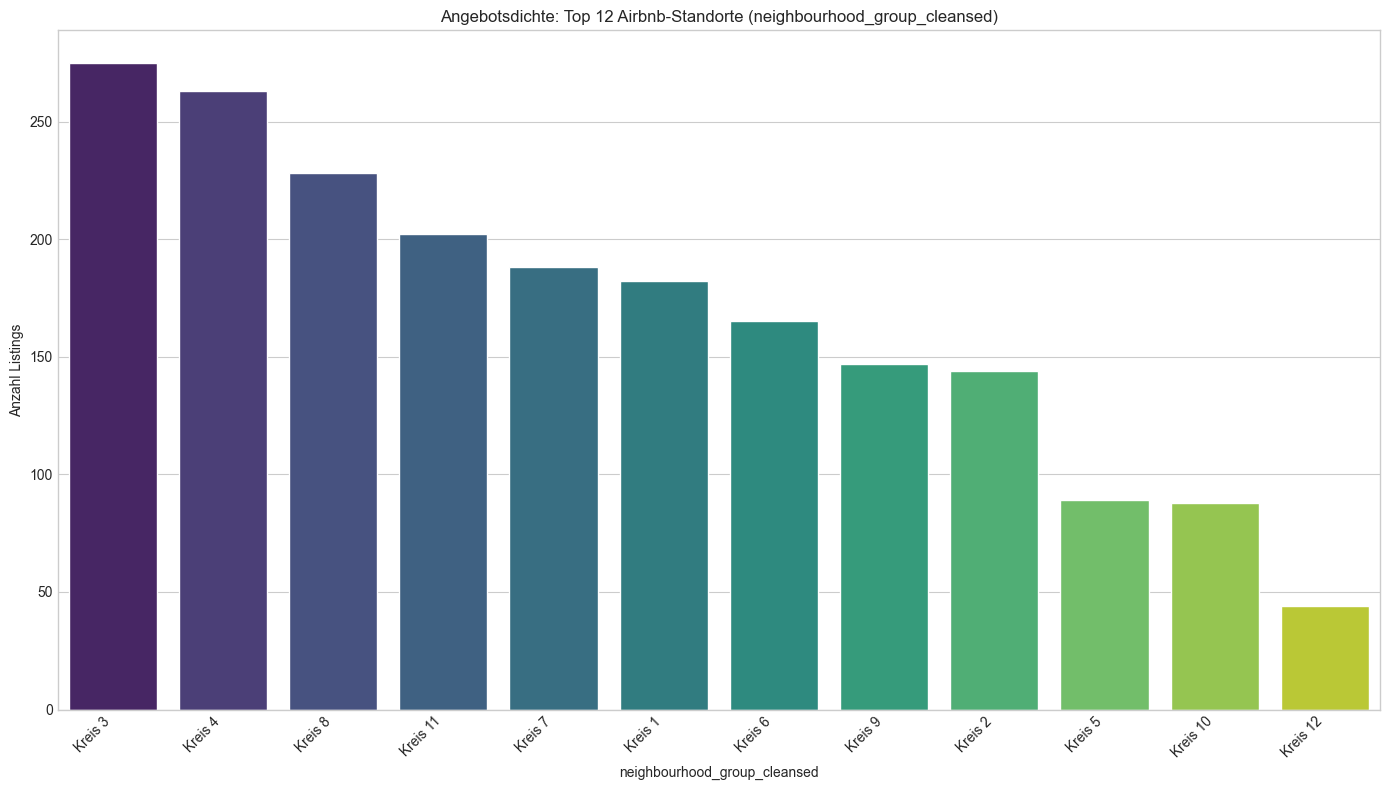

\Häufigste Standorte (Top 5 'neighbourhood_group_cleansed'):
neighbourhood_group_cleansed
Kreis 3     275
Kreis 4     263
Kreis 8     228
Kreis 11    202
Kreis 7     188
Name: count, dtype: int64


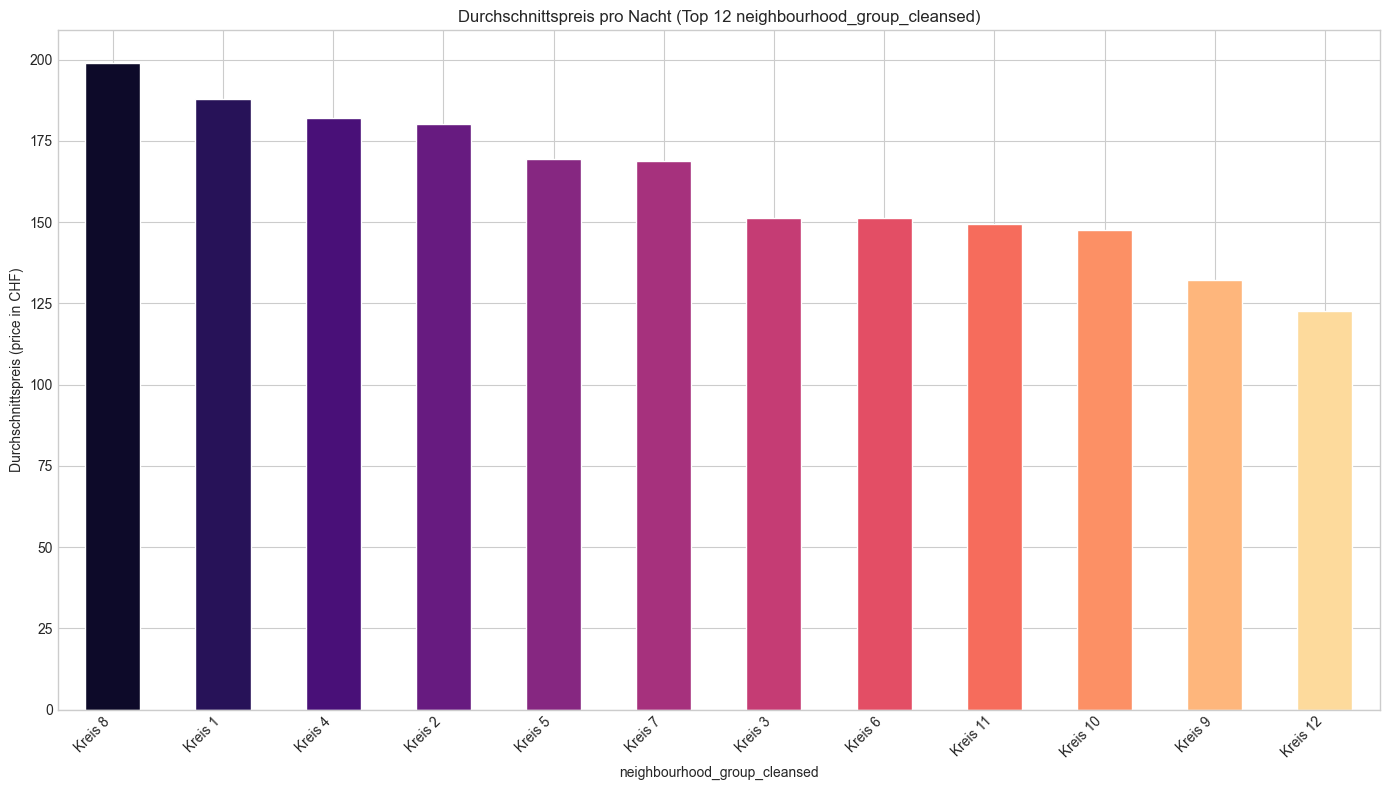


Top 5 Standorte nach Ø-Preis ('neighbourhood_group_cleansed'):
neighbourhood_group_cleansed
Kreis 8    199.026316
Kreis 1    187.730769
Kreis 4    182.148289
Kreis 2    180.180556
Kreis 5    169.539326
Name: price, dtype: float64


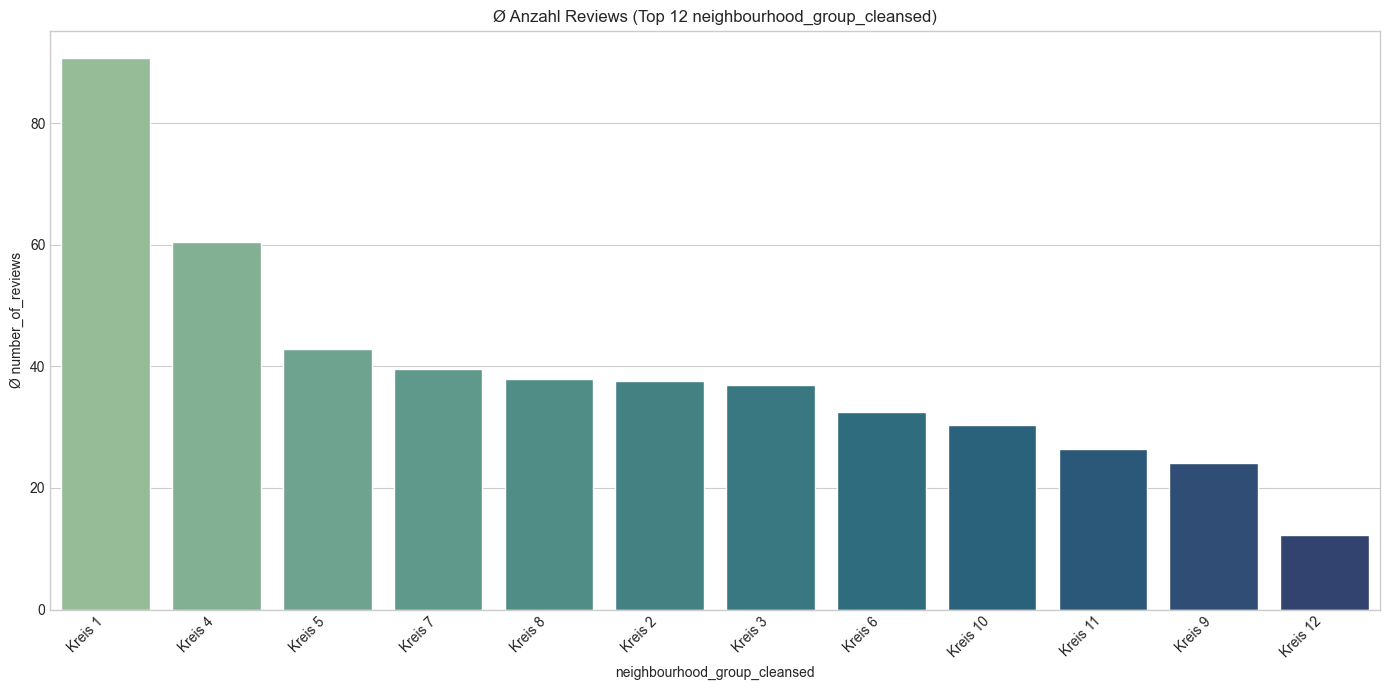

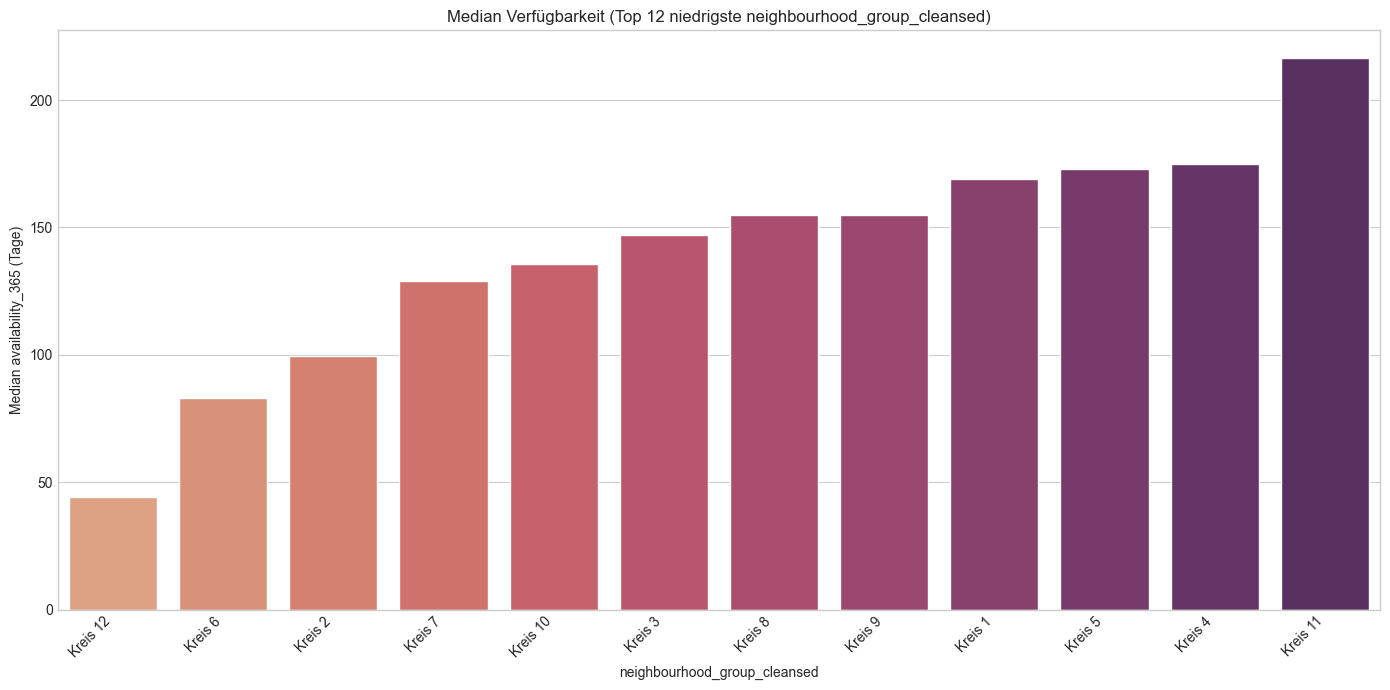


Standorte mit niedrigster Median-Verfügbarkeit (Top 5 'neighbourhood_group_cleansed'):
  neighbourhood_group_cleansed  median_availability_365
3                     Kreis 12                     44.0
8                      Kreis 6                     83.0
4                      Kreis 2                     99.5
9                      Kreis 7                    129.0
1                     Kreis 10                    135.5


/var/folders/7g/gt2l614d19s1z90gtpf3sv180000gn/T/ipykernel_26245/1655953049.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order_roomtype_uc1 = df_plot_rt_uc1.groupby('room_type')['price'].median().sort_values(ascending=False).index
/var/folders/7g/gt2l614d19s1z90gtpf3sv180000gn/T/ipykernel_26245/1655953049.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot_rt_uc1, x='room_type', y='price', palette="pastel", order=order_roomtype_uc1, showfliers=False)


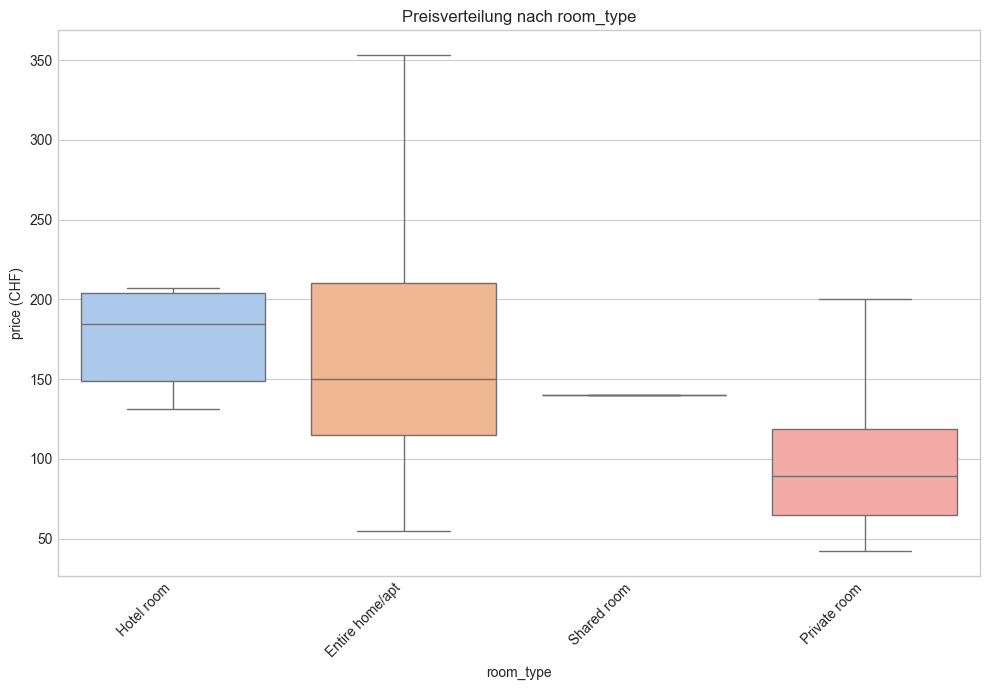

/var/folders/7g/gt2l614d19s1z90gtpf3sv180000gn/T/ipykernel_26245/1655953049.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered_accommodates_uc1, x='accommodates', y='price', order=order_accommodates_uc1, palette="Set3", showfliers=False)


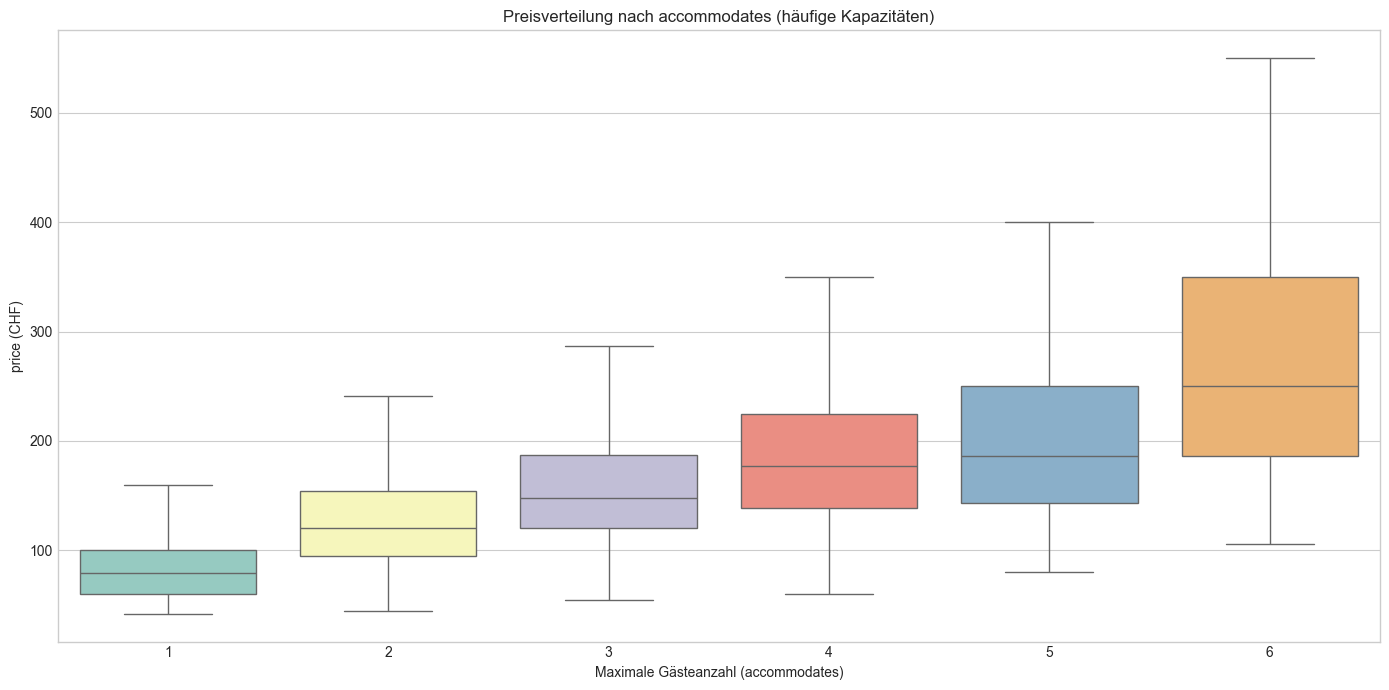

In [9]:
# Use Case 1: Marktpotenzial & Standortanalyse
# Stellt sicher, dass df_analysis und relevante Spalten existieren und gefüllt sind.
# loc_col_for_analysis_notebook wurde im vorherigen Datenaufbereitungs-Block definiert.

if not df_analysis.empty and 'price' in df_analysis.columns and \
   loc_col_for_analysis_notebook in df_analysis.columns and \
   df_analysis[loc_col_for_analysis_notebook].nunique() > 0:

    print(f"\n--- Analysen für Use Case 1 basierend auf Spalte '{loc_col_for_analysis_notebook}' ---")

    # 1. Angebotsdichte pro Standort
    plt.figure(figsize=(14, 8))
    location_counts_uc1 = df_analysis[loc_col_for_analysis_notebook].value_counts()
    top_n_uc1_counts = min(20, location_counts_uc1.nunique())

    if top_n_uc1_counts > 0 and not location_counts_uc1.empty:
        hue_order_lc_uc1 = location_counts_uc1.nlargest(top_n_uc1_counts).index.tolist()
        sns.barplot(x=location_counts_uc1.nlargest(top_n_uc1_counts).index,
                    y=location_counts_uc1.nlargest(top_n_uc1_counts).values,
                    palette="viridis", hue=hue_order_lc_uc1, dodge=False, legend=False)
        plt.title(f'Angebotsdichte: Top {top_n_uc1_counts} Airbnb-Standorte ({loc_col_for_analysis_notebook})')
        plt.xlabel(loc_col_for_analysis_notebook); plt.ylabel('Anzahl Listings'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
        print(f"\Häufigste Standorte (Top 5 '{loc_col_for_analysis_notebook}'):\n{location_counts_uc1.head()}")
    else:
        print(f"Nicht genügend unterschiedliche Standorte in '{loc_col_for_analysis_notebook}' für Plot der Angebotsdichte.")

    # 2. Durchschnittspreis pro Standort
    avg_price_location_uc1 = df_analysis.groupby(loc_col_for_analysis_notebook)['price'].mean().sort_values(ascending=False)
    plt.figure(figsize=(14, 8))
    top_n_prices_uc1 = min(20, avg_price_location_uc1.nunique())

    if top_n_prices_uc1 > 0 and not avg_price_location_uc1.empty:
        avg_price_location_uc1.nlargest(top_n_prices_uc1).plot(kind='bar', color=sns.color_palette("magma", n_colors=top_n_prices_uc1))
        plt.title(f'Durchschnittspreis pro Nacht (Top {top_n_prices_uc1} {loc_col_for_analysis_notebook})')
        plt.xlabel(loc_col_for_analysis_notebook); plt.ylabel(f'Durchschnittspreis (price in CHF)'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
        print(f"\nTop 5 Standorte nach Ø-Preis ('{loc_col_for_analysis_notebook}'):\n{avg_price_location_uc1.head()}")
    else:
        print(f"Nicht genügend Daten für Plot der Durchschnittspreise pro '{loc_col_for_analysis_notebook}'.")

    # 3. Nachfrageindikatoren pro Standort
    if 'number_of_reviews' in df_analysis.columns and 'availability_365' in df_analysis.columns:
        # Sicherstellen, dass die Spalten numerisch sind
        df_analysis['number_of_reviews'] = pd.to_numeric(df_analysis['number_of_reviews'], errors='coerce').fillna(0)
        df_analysis['availability_365'] = pd.to_numeric(df_analysis['availability_365'], errors='coerce')
        if df_analysis['availability_365'].isnull().all() : df_analysis['availability_365'] = df_analysis['availability_365'].fillna(df_analysis['availability_365'].median())

        demand_indicators_uc1 = df_analysis.groupby(loc_col_for_analysis_notebook).agg(
            avg_num_reviews=('number_of_reviews', 'mean'),
            median_availability_365=('availability_365', 'median')
        ).reset_index()

        demand_indicators_uc1_sorted_reviews = demand_indicators_uc1.sort_values(by='avg_num_reviews', ascending=False)
        plt.figure(figsize=(14, 7))
        top_n_demand_uc1_rev = min(15, demand_indicators_uc1_sorted_reviews[loc_col_for_analysis_notebook].nunique())
        if top_n_demand_uc1_rev > 0 and not demand_indicators_uc1_sorted_reviews.empty:
            hue_order_dr_uc1 = demand_indicators_uc1_sorted_reviews.nlargest(top_n_demand_uc1_rev, 'avg_num_reviews')[loc_col_for_analysis_notebook].tolist()
            sns.barplot(data=demand_indicators_uc1_sorted_reviews.nlargest(top_n_demand_uc1_rev, 'avg_num_reviews'),
                        x=loc_col_for_analysis_notebook, y='avg_num_reviews', palette="crest", hue=hue_order_dr_uc1, dodge=False, legend=False)
            plt.title(f'Ø Anzahl Reviews (Top {top_n_demand_uc1_rev} {loc_col_for_analysis_notebook})')
            plt.xlabel(loc_col_for_analysis_notebook); plt.ylabel(f'Ø number_of_reviews'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

        demand_indicators_uc1_sorted_avail = demand_indicators_uc1.sort_values(by='median_availability_365', ascending=True)
        plt.figure(figsize=(14, 7))
        top_n_demand_uc1_avail = min(15, demand_indicators_uc1_sorted_avail[loc_col_for_analysis_notebook].nunique())
        if top_n_demand_uc1_avail > 0 and not demand_indicators_uc1_sorted_avail.empty:
             hue_order_da_uc1 = demand_indicators_uc1_sorted_avail.nsmallest(top_n_demand_uc1_avail, 'median_availability_365')[loc_col_for_analysis_notebook].tolist()
             sns.barplot(data=demand_indicators_uc1_sorted_avail.nsmallest(top_n_demand_uc1_avail, 'median_availability_365'),
                        x=loc_col_for_analysis_notebook, y='median_availability_365', palette="flare", hue=hue_order_da_uc1, dodge=False, legend=False)
             plt.title(f'Median Verfügbarkeit (Top {top_n_demand_uc1_avail} niedrigste {loc_col_for_analysis_notebook})')
             plt.xlabel(loc_col_for_analysis_notebook); plt.ylabel(f'Median availability_365 (Tage)'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
        print(f"\nStandorte mit niedrigster Median-Verfügbarkeit (Top 5 '{loc_col_for_analysis_notebook}'):")
        if not demand_indicators_uc1_sorted_avail.empty: print(demand_indicators_uc1_sorted_avail[[loc_col_for_analysis_notebook, 'median_availability_365']].head())
        else: print("Keine Daten für Verfügbarkeitsranking.")
    else:
        print(f"Warnung: Spalten 'number_of_reviews' oder 'availability_365' für Nachfrageindikatoren nicht gefunden.")

    # 4. Einfluss Unterkunftstyp ('room_type') und Kapazität ('accommodates')
    if 'room_type' in df_analysis.columns and df_analysis['room_type'].nunique() > 0 :
        if 'price' in df_analysis.columns:
            df_plot_rt_uc1 = df_analysis.dropna(subset=['price', 'room_type'])
            if not df_plot_rt_uc1.empty:
                order_roomtype_uc1 = df_plot_rt_uc1.groupby('room_type')['price'].median().sort_values(ascending=False).index
                plt.figure(figsize=(10, 7))
                sns.boxplot(data=df_plot_rt_uc1, x='room_type', y='price', palette="pastel", order=order_roomtype_uc1, showfliers=False)
                plt.title(f'Preisverteilung nach room_type'); plt.xlabel('room_type'); plt.ylabel(f'price (CHF)'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
            else: print("Nicht genügend Daten für Plot Preisverteilung nach room_type.")
    else:
        print(f"Warnung: Spalte 'room_type' nicht im DataFrame oder keine unterschiedlichen Werte.")

    if 'accommodates' in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis['accommodates']) and df_analysis['accommodates'].nunique() > 0:
        accommodates_counts_uc1 = df_analysis['accommodates'].value_counts()
        min_listings_thresh_uc1 = max(10, int(len(df_analysis) * 0.01))
        common_accommodates_uc1 = accommodates_counts_uc1[accommodates_counts_uc1 >= min_listings_thresh_uc1].index

        if not common_accommodates_uc1.empty and 'price' in df_analysis.columns:
            df_filtered_accommodates_uc1 = df_analysis[df_analysis['accommodates'].isin(common_accommodates_uc1)].dropna(subset=['price', 'accommodates'])
            if not df_filtered_accommodates_uc1.empty:
                valid_accommodates_values_uc1 = pd.to_numeric(df_filtered_accommodates_uc1['accommodates'].unique(), errors='coerce')
                valid_accommodates_values_uc1 = valid_accommodates_values_uc1[~np.isnan(valid_accommodates_values_uc1)]
                order_accommodates_uc1 = sorted(valid_accommodates_values_uc1)

                plt.figure(figsize=(14, 7))
                sns.boxplot(data=df_filtered_accommodates_uc1, x='accommodates', y='price', order=order_accommodates_uc1, palette="Set3", showfliers=False)
                plt.title(f'Preisverteilung nach accommodates (häufige Kapazitäten)'); plt.xlabel(f'Maximale Gästeanzahl (accommodates)'); plt.ylabel(f'price (CHF)'); plt.tight_layout(); plt.show()
            else: print("Nicht genügend Daten für Plot Preisverteilung nach accommodates.")
        else:
            print(f"Nicht genügend Daten für aussagekräftigen Plot der Preise nach 'accommodates' oder Preisspalte fehlt.")
    else:
        print(f"Warnung: Spalte 'accommodates' nicht im DataFrame, nicht numerisch oder keine unterschiedlichen Werte.")
else:
    print(f"Analysen für Use Case 1 können nicht durchgeführt werden (DataFrame `df_analysis` leer oder Spalten 'price' / '{loc_col_for_analysis_notebook}' fehlen / haben keine Varianz).")

**Interpretation Use Case 1 (Marktpotenzial & Standortanalyse):**

* **Angebotsdichte:** Der Standort **<font color="red">[Name des Standorts mit meisten Listings ausgeben, z.B. df_analysis[loc_col_for_analysis_notebook].value_counts().index[0]]</font>** weist mit **<font color="red">[Anzahl Listings ausgeben, z.B. df_analysis[loc_col_for_analysis_notebook].value_counts().iloc[0]]</font>** die höchste Anzahl an Airbnb-Angeboten auf. *(Weitere Top-Standorte und Standorte mit wenigen Listings hier kommentieren).*
* **Preisniveaus:** Die höchsten Durchschnittspreise pro Nacht werden in **<font color="red">[Name des teuersten Standorts ausgeben, z.B. avg_price_location_uc1.index[0]]</font>** mit durchschnittlich **<font color="red">[Betrag ausgeben, z.B. avg_price_location_uc1.iloc[0]]</font>** CHF erzielt. *(Weitere Preisbeobachtungen hier).*
* **Nachfrageindikatoren:**
    * **Reviews:** **<font color="red">[Name des Standorts mit meisten Reviews ausgeben]</font>** hat mit durchschnittlich **<font color="red">[Anzahl]</font>** Reviews pro Listing die höchste Review-Anzahl.
    * **Verfügbarkeit:** Die niedrigste Median-Verfügbarkeit findet sich in **<font color="red">[Name des Standorts mit niedrigster Verfügbarkeit ausgeben]</font>** mit **<font color="red">[Anzahl Tage]</font>** Tagen pro Jahr.
* **Unterkunftstyp & Kapazität:**
    * **<font color="red">[Name des teuersten Zimmertyps ausgeben]</font>** erzielen im Median einen Preis von **<font color="red">[Betrag]</font>** CHF. *(Weitere Details zu Zimmertypen).*
    * Listings mit einer Kapazität für **<font color="red">[Anzahl Gäste, z.B. 2]</font>** Personen erzielen einen Medianpreis von **<font color="red">[Betrag]</font>** CHF. *(Weitere Details zu Kapazitäten).*

*(Füge hier eine detailliertere Interpretation deiner spezifischen Plot-Ergebnisse für Use Case 1 ein. Welche Standorte scheinen am vielversprechendsten und warum?)*

### Use Case 2: Preisstrategie & Ertragsprognose

Analyse der Preistreiber und Erstellung eines Regressionsmodells zur Quantifizierung des Einflusses verschiedener Merkmale auf den Preis `price`.


--- Analysen für Use Case 2 (Preisstrategie) ---


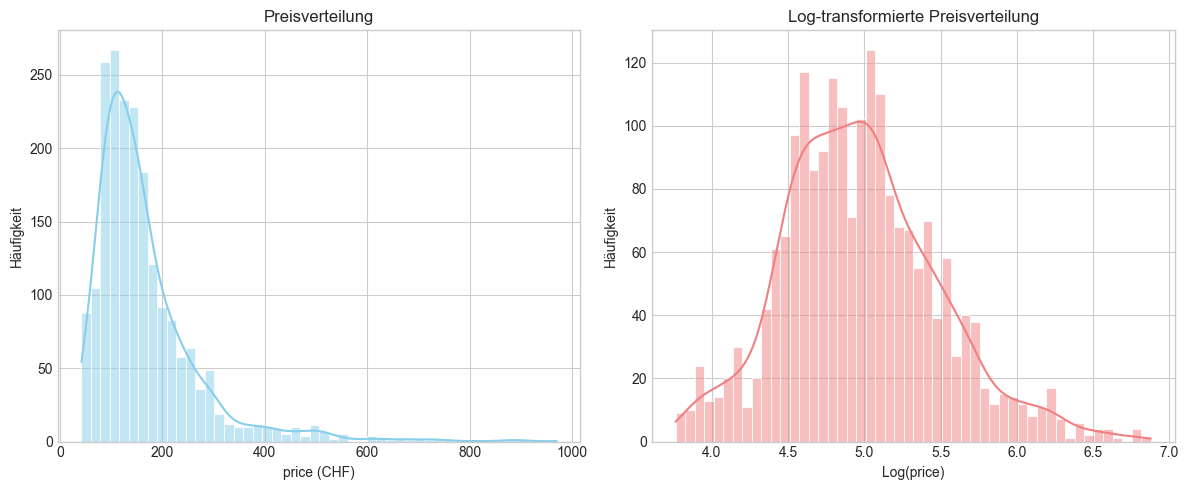

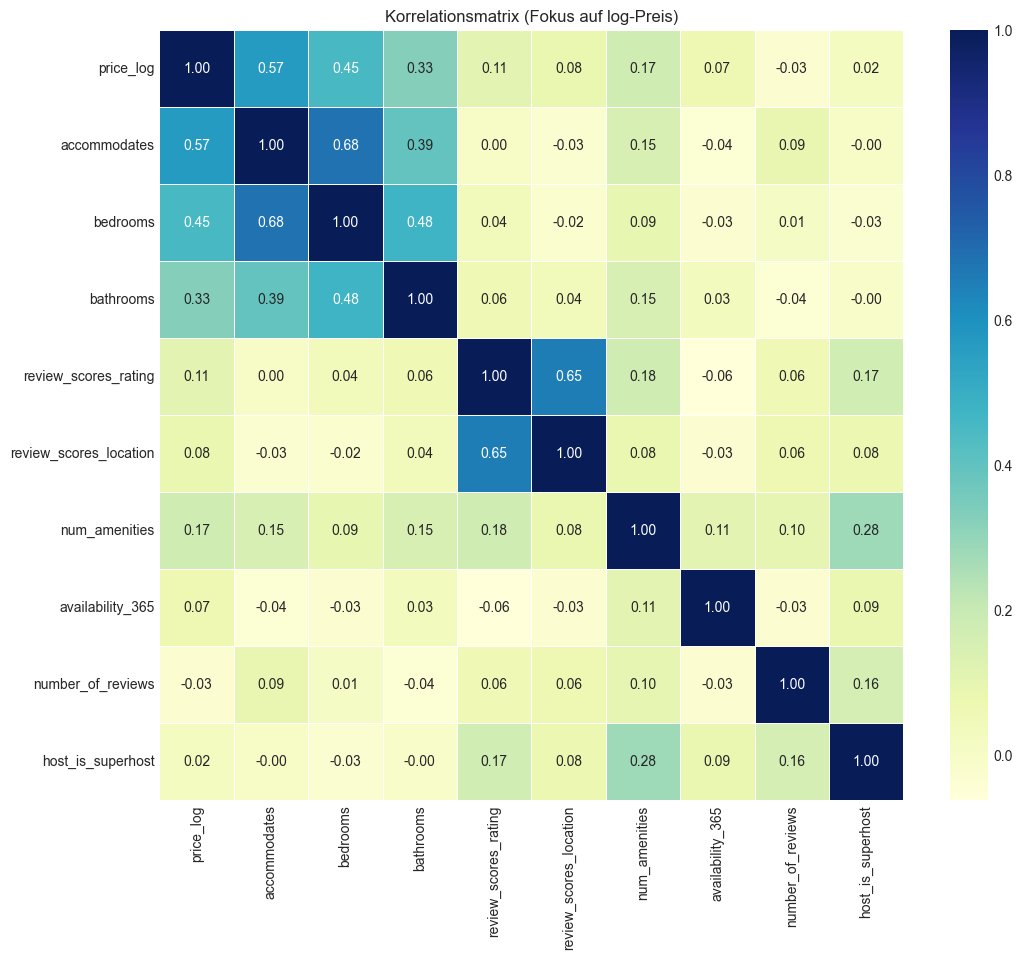


Korrelationen mit 'price_log':
 price_log                 1.000000
accommodates              0.567769
bedrooms                  0.453240
bathrooms                 0.325770
num_amenities             0.174978
review_scores_rating      0.106330
review_scores_location    0.084620
availability_365          0.066410
host_is_superhost         0.023793
number_of_reviews        -0.031103
Name: price_log, dtype: float64

Modell Performance (Lineare Regression - Testdaten): R²=0.4292, RMSE=72.03 CHF
Modell Performance (Lineare Regression - Trainingsdaten): R²=0.4265, RMSE=82.03 CHF

Top Koeffizienten (Lineare Regression - Einfluss auf log-Preis):
                                              Feature  Coefficient_log  \
11                               room_type_Hotel room         0.569476   
12                             room_type_Private room        -0.386104   
14   neighbourhood_group_cleansed_reduced_reg_Kreis 1         0.197563   
0                                        accommodates      

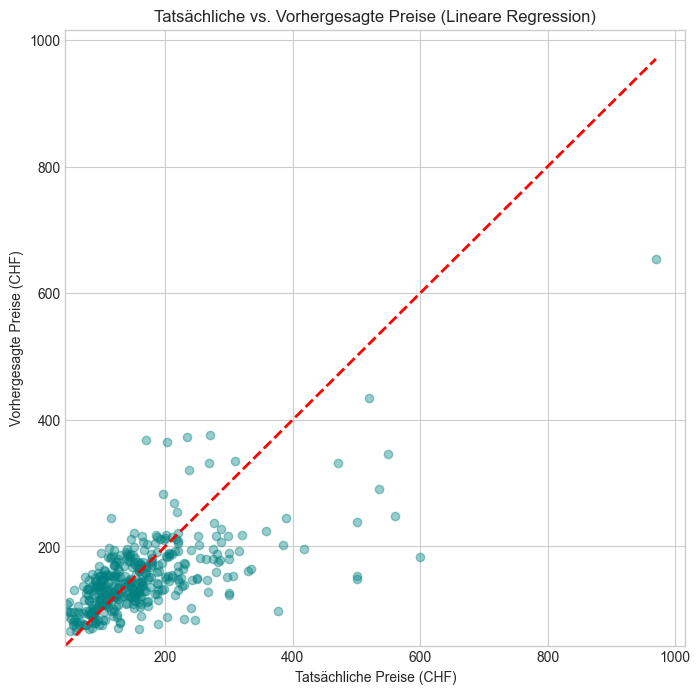

In [10]:
# Use Case 2: Preisstrategie & Ertragsprognose
# Stellt sicher, dass df_analysis, 'price' und 'price_log' korrekt definiert sind und df_analysis nicht leer ist.

if not df_analysis.empty and 'price' in df_analysis.columns and 'price_log' in df_analysis.columns:
    print(f"\n--- Analysen für Use Case 2 (Preisstrategie) ---")

    # Preisverteilung (Original und Log) wurde bereits in der Datenaufbereitung (2.2) gezeigt.
    # Hier ggf. nochmals anzeigen:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); sns.histplot(df_analysis['price'], kde=True, bins=50, color='skyblue'); plt.title('Preisverteilung'); plt.xlabel('price (CHF)'); plt.ylabel('Häufigkeit')
    plt.subplot(1, 2, 2); sns.histplot(df_analysis['price_log'], kde=True, bins=50, color='lightcoral'); plt.title('Log-transformierte Preisverteilung'); plt.xlabel('Log(price)'); plt.ylabel('Häufigkeit')
    plt.tight_layout(); plt.show()

    # Korrelationsmatrix
    cols_for_corr_uc2 = [col for col in ['price_log', 'accommodates', 'bedrooms', 'bathrooms',
                                     'review_scores_rating', 'review_scores_location', 'num_amenities',
                                     'availability_365', 'number_of_reviews', 'host_is_superhost']
                         if col in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis[col])]

    if len(cols_for_corr_uc2) > 1:
        plt.figure(figsize=(12, 10))
        correlation_matrix_uc2 = df_analysis[cols_for_corr_uc2].corr()
        sns.heatmap(correlation_matrix_uc2, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
        plt.title('Korrelationsmatrix (Fokus auf log-Preis)'); plt.show()
        if 'price_log' in correlation_matrix_uc2.columns:
            print("\nKorrelationen mit 'price_log':\n", correlation_matrix_uc2['price_log'].sort_values(ascending=False))
    else:
        print("Nicht genügend gültige numerische Spalten für die Korrelationsmatrix mit log-Preis vorhanden.")

    # --- Regressionsmodell ---
    numeric_features_reg = [col for col in [
                                'accommodates', 'bedrooms', 'bathrooms',
                                'review_scores_rating', 'review_scores_location', 'num_amenities',
                                'availability_365', 'number_of_reviews', 'host_is_superhost', 'host_listings_count']
                            if col in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis[col])]

    categorical_features_reg = []
    if 'room_type' in df_analysis.columns and df_analysis['room_type'].nunique() > 1:
        categorical_features_reg.append('room_type')

    # loc_col_for_analysis_notebook wurde in der Datenaufbereitung global für das Notebook festgelegt
    location_col_reg_reduced_name = f'{loc_col_for_analysis_notebook}_reduced_reg'
    if loc_col_for_analysis_notebook in df_analysis.columns and df_analysis[loc_col_for_analysis_notebook].nunique() > 1:
        top_n_reg = 10
        num_unique_locations_reg = df_analysis[loc_col_for_analysis_notebook].nunique()
        actual_top_n_reg = min(top_n_reg, num_unique_locations_reg -1 if num_unique_locations_reg > 1 else 1)

        if actual_top_n_reg > 0 :
            top_categories_reg = df_analysis[loc_col_for_analysis_notebook].value_counts().nlargest(actual_top_n_reg).index
            df_analysis[location_col_reg_reduced_name] = df_analysis[loc_col_for_analysis_notebook].apply(lambda x: x if x in top_categories_reg else 'Other')
            if location_col_reg_reduced_name not in categorical_features_reg:
                categorical_features_reg.append(location_col_reg_reduced_name)
        elif num_unique_locations_reg == 1 :
             if loc_col_for_analysis_notebook not in categorical_features_reg: categorical_features_reg.append(loc_col_for_analysis_notebook)
             print(f"Warnung (Regression): Standortspalte {loc_col_for_analysis_notebook} hat nur eine Kategorie.")
        else:
            print(f"Warnung (Regression): Standortspalte {loc_col_for_analysis_notebook} nicht für OHE mit Top-N-Reduktion verwendet.")

    target_reg = 'price_log'
    final_feature_list_reg = [f for f in numeric_features_reg + categorical_features_reg if f in df_analysis.columns and f is not None]

    if not all(f in df_analysis.columns for f in final_feature_list_reg + [target_reg]):
        missing_cols_for_reg = [f for f in final_feature_list_reg + [target_reg] if f not in df_analysis.columns]
        print(f"FEHLER (Regression): Folgende Spalten fehlen: {missing_cols_for_reg}. Überspringe Regression.")
    elif df_analysis[target_reg].isnull().all() or (final_feature_list_reg and df_analysis[final_feature_list_reg].isnull().all().all()):
         print(f"FEHLER (Regression): Zielvariable oder alle Features enthalten nur NaN-Werte.")
    elif df_analysis[target_reg].nunique() < 2:
        print(f"FEHLER (Regression): Zielvariable '{target_reg}' hat nicht genügend unterschiedliche Werte.")
    elif not final_feature_list_reg :
        print(f"FEHLER (Regression): Keine Features für das Modell ausgewählt.")
    else:
        X_reg = df_analysis[final_feature_list_reg].copy()
        y_reg = df_analysis[target_reg].copy()

        valid_indices_reg = y_reg.notna() & X_reg.notna().all(axis=1)
        X_reg = X_reg[valid_indices_reg]; y_reg = y_reg[valid_indices_reg]

        if X_reg.empty or y_reg.empty or len(X_reg) < max(20, len(final_feature_list_reg)*2):
            print("Nicht genügend Daten für Regression nach NaN-Filterung oder zu wenige Zeilen für die Anzahl der Features.")
        else:
            X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

            actual_numeric_features_reg_pipe = [col for col in numeric_features_reg if col in X_train_reg.columns]
            actual_categorical_features_reg_pipe = [col for col in categorical_features_reg if col in X_train_reg.columns and col is not None]

            numeric_transformer_reg = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
            categorical_transformer_reg = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

            transformers_list_reg = []
            if actual_numeric_features_reg_pipe: transformers_list_reg.append(('num', numeric_transformer_reg, actual_numeric_features_reg_pipe))
            if actual_categorical_features_reg_pipe: transformers_list_reg.append(('cat', categorical_transformer_reg, actual_categorical_features_reg_pipe))

            if not transformers_list_reg:
                 print("FEHLER (Regression): Keine Features für Preprocessing Pipeline definiert.")
            else:
                preprocessor_reg = ColumnTransformer(transformers=transformers_list_reg, remainder='drop') # remainder='drop' to avoid issues with unhandled columns

                model_reg = Pipeline(steps=[('preprocessor', preprocessor_reg), ('regressor', LinearRegression())])
                model_reg.fit(X_train_reg, y_train_reg)

                y_pred_log_train_reg = model_reg.predict(X_train_reg); y_pred_log_test_reg = model_reg.predict(X_test_reg)
                y_pred_train_actual_reg = np.expm1(y_pred_log_train_reg); y_pred_test_actual_reg = np.expm1(y_pred_log_test_reg)
                y_train_actual_reg = np.expm1(y_train_reg); y_test_actual_reg = np.expm1(y_test_reg)
                y_pred_train_actual_reg[y_pred_train_actual_reg < 0] = 0; y_pred_test_actual_reg[y_pred_test_actual_reg < 0] = 0

                r2_test_reg_score = r2_score(y_test_actual_reg, y_pred_test_actual_reg)
                rmse_test_reg_val = np.sqrt(mean_squared_error(y_test_actual_reg, y_pred_test_actual_reg))
                r2_train_reg_score = r2_score(y_train_actual_reg, y_pred_train_actual_reg)
                rmse_train_reg_val = np.sqrt(mean_squared_error(y_train_actual_reg, y_pred_train_actual_reg))

                print(f"\nModell Performance (Lineare Regression - Testdaten): R²={r2_test_reg_score:.4f}, RMSE={rmse_test_reg_val:.2f} CHF")
                print(f"Modell Performance (Lineare Regression - Trainingsdaten): R²={r2_train_reg_score:.4f}, RMSE={rmse_train_reg_val:.2f} CHF")

                if isinstance(model_reg.named_steps['regressor'], LinearRegression):
                    try:
                        processed_feature_names_reg = []
                        # Iteriere durch die Transformer im ColumnTransformer, um die Feature-Namen korrekt zu erhalten
                        for name_trans, trans_pipe, cols_trans in model_reg.named_steps['preprocessor'].transformers_:
                            if trans_pipe == 'drop' or cols_trans == []: continue # Überspringe 'drop' oder leere Spaltenlisten
                            if name_trans == 'num' and 'scaler' in trans_pipe.named_steps : # Numerische Features
                                processed_feature_names_reg.extend(cols_trans)
                            elif name_trans == 'cat' and 'onehot' in trans_pipe.named_steps: # Kategoriale Features
                                ohe_feature_names = trans_pipe.named_steps['onehot'].get_feature_names_out(cols_trans)
                                processed_feature_names_reg.extend(list(ohe_feature_names))

                        if len(processed_feature_names_reg) == len(model_reg.named_steps['regressor'].coef_):
                            coefficients_reg_df = pd.DataFrame({'Feature': processed_feature_names_reg, 'Coefficient_log': model_reg.named_steps['regressor'].coef_})
                            coefficients_reg_df['Coefficient_approx_perc_change'] = (np.exp(coefficients_reg_df['Coefficient_log']) - 1) * 100
                            coefficients_reg_df['Absolute_Coefficient_log'] = coefficients_reg_df['Coefficient_log'].abs()
                            print("\nTop Koeffizienten (Lineare Regression - Einfluss auf log-Preis):")
                            print(coefficients_reg_df.sort_values(by='Absolute_Coefficient_log', ascending=False).drop(columns='Absolute_Coefficient_log').head(20))
                        else:
                             print(f"Warnung: Anzahl der Feature-Namen ({len(processed_feature_names_reg)}) stimmt nicht mit Anzahl der Koeffizienten ({len(model_reg.named_steps['regressor'].coef_)}) überein. Koeffizienten werden nicht korrekt angezeigt.")
                    except Exception as e: print(f"Fehler bei Koeffizienten-Extraktion (Regression): {e}")

                plt.figure(figsize=(8, 8)); plt.scatter(y_test_actual_reg, y_pred_test_actual_reg, alpha=0.4, color='teal')
                min_val_reg = max(0, min(y_test_actual_reg.min(), y_pred_test_actual_reg.min())); max_val_reg = max(y_test_actual_reg.max(), y_pred_test_actual_reg.max())
                plt.plot([min_val_reg, max_val_reg], [min_val_reg, max_val_reg], 'r--', lw=2)
                plt.xlabel('Tatsächliche Preise (CHF)'); plt.ylabel('Vorhergesagte Preise (CHF)'); plt.title('Tatsächliche vs. Vorhergesagte Preise (Lineare Regression)'); plt.xlim(left=min_val_reg); plt.ylim(bottom=min_val_reg); plt.show()
else:
    print("Analysen für Use Case 2 (Regression) können nicht durchgeführt werden (df_analysis leer oder 'price'/'price_log' fehlt).")

**Interpretation Use Case 2 (Preisstrategie & Ertragsprognose):**

* **Preisverteilung & Transformation:** Die Log-Transformation der Variable `price` hat die Verteilung normalisiert (Median ursprünglicher Preis: **<font color="red">[Median von df_analysis['price'] einfügen]</font>** CHF), was die Annahmen linearer Modelle besser erfüllt.
* **Korrelationen:** **<font color="red">[Name des stärksten korrelierenden numerischen Features mit price_log ausgeben]</font>** korreliert mit **<font color="red">[Korrelationswert]</font>** am stärksten positiv mit dem `price_log`. *(Weitere Korrelationen hier kommentieren).*
* **Modell-Performance (Lineare Regression):**
    * Das <span class="math-inline">R^2</span> auf den Testdaten beträgt **<font color="red">[r2_test_reg_score einfügen]</font>**, d.h. das Modell erklärt ca. **<font color="red">[r2_test_reg_score * 100]%</font>** der Varianz im (log-transformierten) Preis.
    * Der RMSE auf den Testdaten liegt bei **<font color="red">[rmse_test_reg_val einfügen]</font>** CHF.
    * Die Trainings-Performance (<span class="math-inline">R^2</span>: **<font color="red">[r2_train_reg_score]</font>**, RMSE: **<font color="red">[rmse_train_reg_val]</font>** CHF) ist **<font color="red">[ähnlich/besser/schlechter]</font>** als die Test-Performance, was auf **<font color="red">[wenig/etwas/starkes]</font>** Overfitting hindeutet.
* **Preistreiber (Koeffizienten der Linearen Regression):**
    * *(Die wichtigsten Koeffizienten aus der Ausgabe `coefficients_reg_df` auflisten und interpretieren. Beachte, dass die Koeffizienten den Einfluss auf den *logarithmierten* Preis zeigen. Ein Koeffizient von `b` bedeutet eine ungefähre prozentuale Änderung von `(np.exp(b)-1)*100%` im Preis für jede Einheit des Merkmals oder im Vergleich zur Referenzkategorie bei Dummy-Variablen.)*
        * Z.B.: "Ein zusätzliches Schlafzimmer (`bedrooms`) ist mit einer Preisänderung von ca. **<font color="red">[Prozentuale Änderung für bedrooms berechnen und einfügen]</font>**% assoziiert."
        * "Listings im Standort **<font color="red">[Name eines Dummy-Standorts mit hohem Koeffizienten]</font>** sind tendenziell um **<font color="red">[Prozentuale Änderung berechnen und einfügen]</font>**% teurer als der Referenzstandort ('Other')."
* **Streudiagramm (Tatsächlich vs. Vorhergesagt):** *(Kommentiere die Streuung der Punkte um die diagonale Linie).*

### Use Case 3: Performance Optimierung & Benchmarking

Analyse der Unterscheidungsmerkmale von Superhosts `host_is_superhost` und Modellierung zur Vorhersage dieses Status.


--- Analysen für Use Case 3 ('host_is_superhost') ---

Vergleich: Ø-Metriken Superhosts vs. Nicht-Superhosts:
                                       0           1
Ist Superhost (1=Ja, 0=Nein)    0.000000    1.000000
price                         162.784457  173.262673
review_scores_rating            4.639150    4.820922
number_of_reviews              32.818182   62.239631
num_amenities                  26.853372   35.290323
host_response_rate              0.926356    0.992995
availability_365              157.451613  181.548387
reviews_per_month               1.329054    1.774977


/var/folders/7g/gt2l614d19s1z90gtpf3sv180000gn/T/ipykernel_26245/3302137508.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='host_is_superhost', y=metric, data=df_uc3_desc, ax=axes[i], palette="coolwarm", showfliers=False)
/var/folders/7g/gt2l614d19s1z90gtpf3sv180000gn/T/ipykernel_26245/3302137508.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_title(f'{metric} nach Superhost-Status'); axes[i].set_xticklabels(['Nicht-Superhost', 'Superhost'])
/var/folders/7g/gt2l614d19s1z90gtpf3sv180000gn/T/ipykernel_26245/3302137508.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='host_is_sup

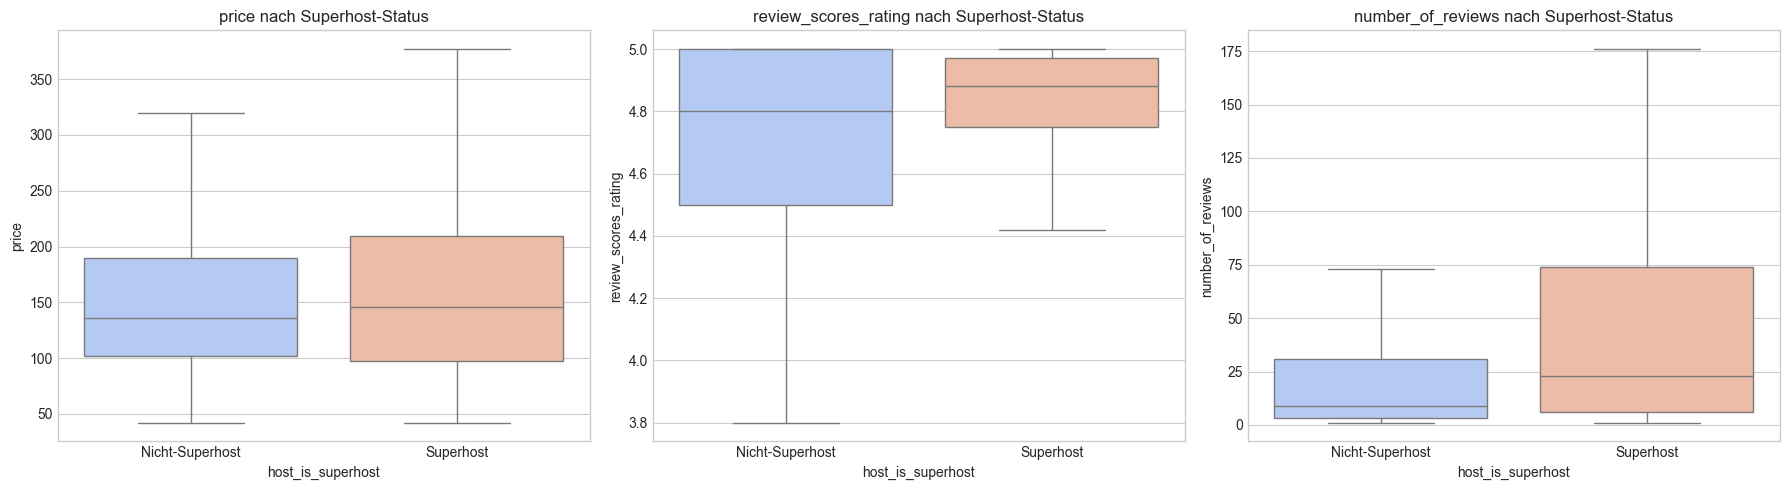


--- Training & Evaluation: Logistic Regression für Superhost-Status ---
                 precision    recall  f1-score   support

Nicht-Superhost       0.88      0.63      0.73       410
      Superhost       0.51      0.82      0.63       195

       accuracy                           0.69       605
      macro avg       0.70      0.72      0.68       605
   weighted avg       0.76      0.69      0.70       605



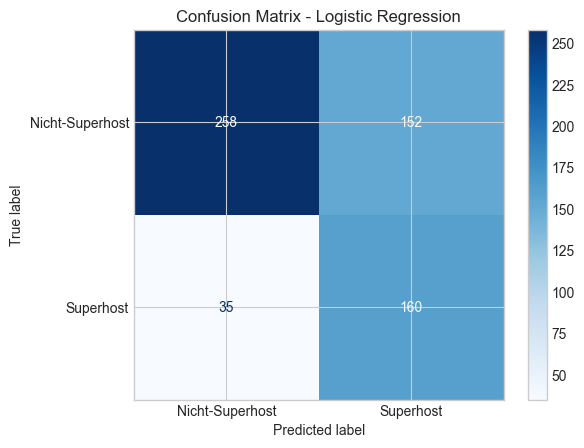

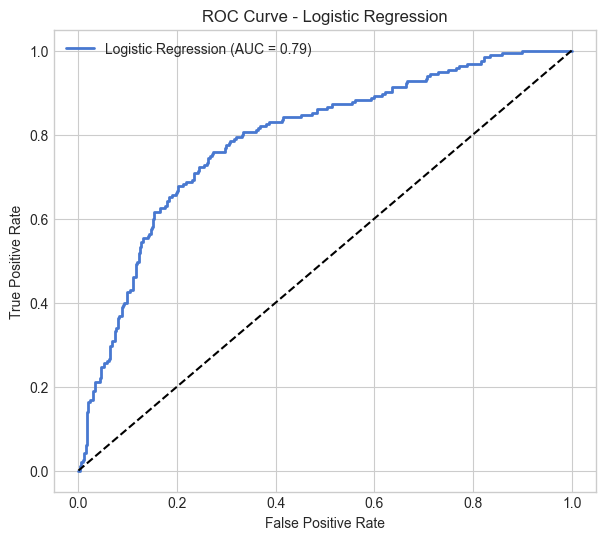

Hinweis: Konnte Feature-Namen für Logistic Regression (SH) nicht vollständig extrahieren: dictionary update sequence element #0 has length 3; 2 is required

--- Training & Evaluation: Random Forest für Superhost-Status ---
                 precision    recall  f1-score   support

Nicht-Superhost       0.91      0.87      0.89       410
      Superhost       0.75      0.83      0.79       195

       accuracy                           0.85       605
      macro avg       0.83      0.85      0.84       605
   weighted avg       0.86      0.85      0.86       605



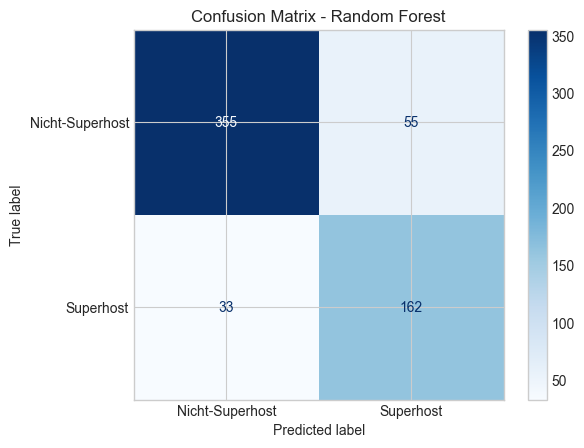

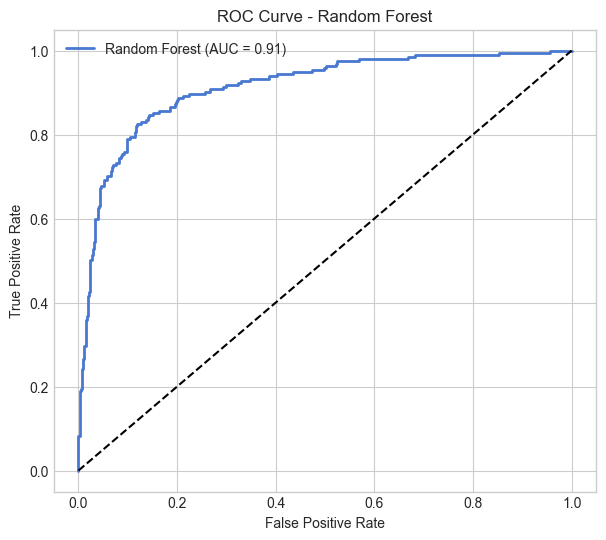

Hinweis: Konnte Feature-Namen für Random Forest (SH) nicht vollständig extrahieren: dictionary update sequence element #0 has length 3; 2 is required


In [11]:
# Use Case 3: Superhost Analyse & Klassifikation
# Stellt sicher, dass df_analysis und relevante Spalten existieren.

if not df_analysis.empty and 'host_is_superhost' in df_analysis.columns and 'price' in df_analysis.columns:
    print(f"\n--- Analysen für Use Case 3 ('host_is_superhost') ---")

    # Deskriptive Analyse: Superhosts vs. Nicht-Superhosts
    comparison_metrics_uc3 = [col for col in ['price', 'review_scores_rating', 'number_of_reviews',
                                           'num_amenities', 'host_response_rate', 'availability_365',
                                           'reviews_per_month']
                              if col in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis[col])]
    if comparison_metrics_uc3:
        df_uc3_desc = df_analysis.dropna(subset=['host_is_superhost'] + comparison_metrics_uc3)

        if not df_uc3_desc.empty and df_uc3_desc['host_is_superhost'].nunique() > 1:
            superhost_comparison_df = df_uc3_desc.groupby('host_is_superhost')[comparison_metrics_uc3].mean().reset_index()
            superhost_comparison_df = superhost_comparison_df.rename(columns={'host_is_superhost': 'Ist Superhost (1=Ja, 0=Nein)'})
            print("\nVergleich: Ø-Metriken Superhosts vs. Nicht-Superhosts:")
            print(superhost_comparison_df.T)

            num_metrics_to_plot_uc3 = len(comparison_metrics_uc3)
            if num_metrics_to_plot_uc3 > 0:
                num_plots_uc3 = min(num_metrics_to_plot_uc3, 3)
                fig, axes = plt.subplots(1, num_plots_uc3, figsize=(num_plots_uc3 * 6, 5))
                if num_plots_uc3 == 1: axes = [axes]

                for i, metric in enumerate(comparison_metrics_uc3[:num_plots_uc3]):
                    sns.boxplot(x='host_is_superhost', y=metric, data=df_uc3_desc, ax=axes[i], palette="coolwarm", showfliers=False)
                    axes[i].set_title(f'{metric} nach Superhost-Status'); axes[i].set_xticklabels(['Nicht-Superhost', 'Superhost'])
                plt.tight_layout(); plt.show()
        else:
            print("Nicht genügend Daten oder Klassen für deskriptive Superhost-Analyse nach NaN-Bereinigung.")
    else:
        print("Nicht genügend numerische Vergleichsmetriken für Superhost-Deskriptivanalyse vorhanden.")

    # --- Klassifikationsmodell zur Vorhersage des Superhost-Status ---
    numeric_features_sh = [col for col in [
        'review_scores_rating', 'review_scores_cleanliness', 'review_scores_communication',
        'review_scores_checkin', 'review_scores_location', 'review_scores_value',
        'host_response_rate', 'host_acceptance_rate_percent', 'number_of_reviews',
        'reviews_per_month', 'num_amenities', 'host_listings_count',
        'host_identity_verified', 'availability_365', 'price'
        ] if col in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis[col])]

    categorical_features_sh = []
    if 'host_response_time' in df_analysis.columns and df_analysis['host_response_time'].nunique() > 1:
        categorical_features_sh.append('host_response_time')

    target_sh = 'host_is_superhost'
    final_feature_list_sh = numeric_features_sh + categorical_features_sh

    if not all(f in df_analysis.columns for f in final_feature_list_sh + [target_sh]):
        missing_cols_for_sh = [f for f in final_feature_list_sh + [target_sh] if f not in df_analysis.columns]
        print(f"FEHLER (Superhost Klassifikation): Folgende Spalten fehlen: {missing_cols_for_sh}.")
    elif df_analysis[target_sh].nunique() < 2: # Prüfen auf mindestens zwei Klassen
        print(f"FEHLER (Superhost Klassifikation): Zielvariable '{target_sh}' hat nicht genügend Klassen. Verteilung:\n{df_analysis[target_sh].value_counts(normalize=True)}")
    elif df_analysis[final_feature_list_sh + [target_sh]].isnull().all().any(): # Prüfen ob ganze Spalten nur NaN sind
         print(f"FEHLER (Superhost Klassifikation): Benötigte Spalten enthalten nur NaN-Werte.")
    else:
        X_sh = df_analysis[final_feature_list_sh].copy()
        y_sh = df_analysis[target_sh].copy()

        valid_indices_sh = y_sh.notna() & X_sh.notna().all(axis=1)
        X_sh = X_sh[valid_indices_sh]; y_sh = y_sh[valid_indices_sh]

        if X_sh.empty or y_sh.empty or y_sh.nunique() < 2 or len(X_sh) < 50:
            print("Nach NaNs-Entfernung oder aufgrund fehlender Klassen/Datenmenge keine Daten für Superhost-Modell übrig.")
        else:
            X_train_sh, X_test_sh, y_train_sh, y_test_sh = train_test_split(X_sh, y_sh, test_size=0.3, random_state=42, stratify=y_sh)

            actual_numeric_features_sh_pipe = [col for col in numeric_features_sh if col in X_train_sh.columns]
            actual_categorical_features_sh_pipe = [col for col in categorical_features_sh if col in X_train_sh.columns]

            numeric_transformer_sh = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
            categorical_transformer_sh = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

            transformers_list_sh = []
            if actual_numeric_features_sh_pipe: transformers_list_sh.append(('num', numeric_transformer_sh, actual_numeric_features_sh_pipe))
            if actual_categorical_features_sh_pipe: transformers_list_sh.append(('cat', categorical_transformer_sh, actual_categorical_features_sh_pipe))

            if not transformers_list_sh:
                print("FEHLER (Superhost Klassifikation): Keine Features für Preprocessing Pipeline definiert.")
            else:
                preprocessor_sh = ColumnTransformer(transformers=transformers_list_sh, remainder='drop')

                models_sh_dict = {
                    "Logistic Regression": LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42, C=0.1),
                    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1, max_depth=10, min_samples_leaf=5)
                }

                for model_name, model_sh_instance in models_sh_dict.items():
                    print(f"\n--- Training & Evaluation: {model_name} für Superhost-Status ---")
                    pipeline_sh_model = Pipeline(steps=[('preprocessor', preprocessor_sh), ('classifier', model_sh_instance)])
                    pipeline_sh_model.fit(X_train_sh, y_train_sh)
                    y_pred_sh_test = pipeline_sh_model.predict(X_test_sh)

                    if hasattr(pipeline_sh_model, "predict_proba"): y_proba_sh_test = pipeline_sh_model.predict_proba(X_test_sh)[:, 1]
                    else: y_proba_sh_test = y_pred_sh_test

                    print(classification_report(y_test_sh, y_pred_sh_test, target_names=['Nicht-Superhost', 'Superhost'], zero_division=0))
                    cm_sh = confusion_matrix(y_test_sh, y_pred_sh_test); disp_sh = ConfusionMatrixDisplay(cm_sh, display_labels=['Nicht-Superhost', 'Superhost'])
                    disp_sh.plot(cmap="Blues"); plt.title(f'Confusion Matrix - {model_name}'); plt.show()

                    if y_sh.nunique() > 1 and len(np.unique(y_test_sh)) > 1 : # ROC nur wenn binär und beide Klassen im Testset
                        fpr_sh, tpr_sh, _ = roc_curve(y_test_sh, y_proba_sh_test)
                        auc_score_sh = roc_auc_score(y_test_sh, y_proba_sh_test)
                        plt.figure(figsize=(7,6)); plt.plot(fpr_sh, tpr_sh, label=f'{model_name} (AUC = {auc_score_sh:.2f})', lw=2)
                        plt.plot([0, 1], [0, 1], 'k--'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(f'ROC Curve - {model_name}'); plt.legend(); plt.show()

                    # Feature Importance / Coefficients
                    feature_names_transformed_sh = None
                    try:
                        temp_feature_names_sh = []
                        if actual_numeric_features_sh_pipe: temp_feature_names_sh.extend(actual_numeric_features_sh_pipe)
                        if actual_categorical_features_sh_pipe:
                            # Prüfe, ob der OneHotEncoder im Transformer 'cat' existiert und Features generiert hat
                            if 'cat' in dict(pipeline_sh_model.named_steps['preprocessor'].transformers) and \
                               hasattr(pipeline_sh_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'], 'get_feature_names_out'):
                                ohe_feature_names_sh = pipeline_sh_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(actual_categorical_features_sh_pipe)
                                temp_feature_names_sh.extend(list(ohe_feature_names_sh))
                        if temp_feature_names_sh: feature_names_transformed_sh = temp_feature_names_sh
                    except Exception as e_fn:
                        print(f"Hinweis: Konnte Feature-Namen für {model_name} (SH) nicht vollständig extrahieren: {e_fn}")

                    if feature_names_transformed_sh: # Nur wenn Namen extrahiert werden konnten
                        if hasattr(pipeline_sh_model.named_steps['classifier'], 'feature_importances_'):
                            importances_sh = pipeline_sh_model.named_steps['classifier'].feature_importances_
                            if len(feature_names_transformed_sh) == len(importances_sh):
                                feature_importance_sh_df = pd.DataFrame({'Feature': feature_names_transformed_sh, 'Importance': importances_sh}).sort_values(by='Importance', ascending=False)
                                plt.figure(figsize=(10, max(5, len(feature_importance_sh_df.head(15)) * 0.4) ));
                                sns.barplot(x='Importance', y='Feature', data=feature_importance_sh_df.head(15), palette="cubehelix");
                                plt.title(f'Top 15 Feature Importances - {model_name}'); plt.tight_layout(); plt.show()
                                print("\nTop 10 Feature Importances:"); print(feature_importance_sh_df.head(10))
                            else: print(f"Längenkonflikt bei Feature Importance für {model_name} (SH). Erwartet: {len(importances_sh)}, Bekommen: {len(feature_names_transformed_sh)}")

                        elif hasattr(pipeline_sh_model.named_steps['classifier'], 'coef_') and model_name == "Logistic Regression":
                            coefficients_sh = pipeline_sh_model.named_steps['classifier'].coef_[0]
                            if len(feature_names_transformed_sh) == len(coefficients_sh):
                                feature_coeffs_sh_df = pd.DataFrame({'Feature': feature_names_transformed_sh, 'Coefficient': coefficients_sh})
                                feature_coeffs_sh_df['Abs_Coefficient'] = feature_coeffs_sh_df['Coefficient'].abs()
                                feature_coeffs_sh_df = feature_coeffs_sh_df.sort_values(by='Abs_Coefficient', ascending=False)
                                plt.figure(figsize=(10, max(5, len(feature_coeffs_sh_df.head(15)) * 0.4) ));
                                sns.barplot(x='Coefficient', y='Feature', data=feature_coeffs_sh_df.head(15), palette="Spectral");
                                plt.title(f'Top 15 Coefficients - {model_name}'); plt.tight_layout(); plt.show()
                                print("\nTop 10 Coefficients:"); print(feature_coeffs_sh_df[['Feature', 'Coefficient']].head(10))
                            else: print(f"Längenkonflikt bei Koeffizienten für {model_name} (SH). Erwartet: {len(coefficients_sh)}, Bekommen: {len(feature_names_transformed_sh)}")
else:
    print("Analysen für Use Case 3 (Superhosts) können nicht durchgeführt werden (df_analysis leer oder relevante Spalten fehlen).")

**Interpretation Use Case 3 (Performance Optimierung & Benchmarking):**

* **Deskriptive Unterschiede:**
    * Superhosts haben im Durchschnitt einen `review_scores_rating` von **<font color="red">[Wert aus superhost_comparison_df für Superhosts]</font>** vs. **<font color="red">[Wert für Nicht-Superhosts]</font>**.
    * Der durchschnittliche Preis `price' für Superhosts ist **<font color="red">[höher/niedriger/ähnlich]</font>** und beträgt **<font color="red">[Wert]</font>** CHF, bei Nicht-Superhosts **<font color="red">[Wert]</font>** CHF.
    * *(Ergänze weitere Beobachtungen zu `number_of_reviews`, `num_amenities`, `host_response_rate` etc. aus der `superhost_comparison_df` Tabelle und den Boxplots).*
* **Modell-Performance (Klassifikation Superhost-Status):**
    * **Logistic Regression:**
        * AUC: **<font color="red">[AUC-Wert]</font>**. Accuracy: **<font color="red">[Accuracy]</font>**. Precision (Superhost): **<font color="red">[Precision]</font>**. Recall (Superhost): **<font color="red">[Recall]</font>**. F1-Score (Superhost): **<font color="red">[F1]</font>**.
        * *(Bewerte die Performance der Logistic Regression).*
    * **Random Forest Classifier:**
        * AUC: **<font color="red">[AUC-Wert]</font>**. Accuracy: **<font color="red">[Accuracy]</font>**. Precision (Klasse Superhost): **<font color="red">[Precision]</font>**. Recall (Klasse Superhost): **<font color="red">[Recall]</font>**. F1-Score (Klasse Superhost): **<font color="red">[F1]</font>**.
        * *(Vergleiche mit Logistic Regression. Welches Modell ist besser?)*
* **Wichtigste Prädiktoren für Superhost-Status (aus Feature Importance/Coefficients des besten Modells):**
    * Die Top 3 Features sind: 1. **<font color="red">[Name Feature 1]</font>** (Importance/Abs_Coefficient: **<font color="red">[Wert]</font>**), 2. **<font color="red">[Name Feature 2]</font>** (Importance/Abs_Coefficient: **<font color="red">[Wert]</font>**), 3. **<font color="red">[Name Feature 3]</font>** (Importance/Abs_Coefficient: **<font color="red">[Wert]</font>**).
    * *(Interpretation dieser Features).*

*(Hinweis zu SHAP-Werten: Für eine noch tiefere Modellinterpretation könnten SHAP-Werte analysiert werden.)*

### Use Case 4: Listing-Optimierung durch Textanalyse

Untersuchung des Einflusses von Textinhalten (aus `description`) auf die Listing-Performance.


--- Analysen für Use Case 4 (NLP) basierend auf Spalte 'description' ---
NLP-Analyse wird auf einer Stichprobe von 1000 Listings für 'description' durchgeführt.

--- Textdaten-Vorbereitung für NLP ---
Beginne mit der Textvorverarbeitung für NLP (kann etwas dauern)...
Textvorverarbeitung abgeschlossen.

Beispiel für bereinigte Beschreibung:
enjoy stylish experience centrally located

--- Sentiment Analyse ---

Deskriptive Statistiken für Sentiment-Scores:
       sentiment_polarity  sentiment_subjectivity
count         1000.000000             1000.000000
mean             0.252684                0.486395
std              0.163576                0.191679
min             -0.200000                0.000000
25%              0.133333                0.390000
50%              0.255556                0.495627
75%              0.350000                0.602320
max              0.925000                1.000000


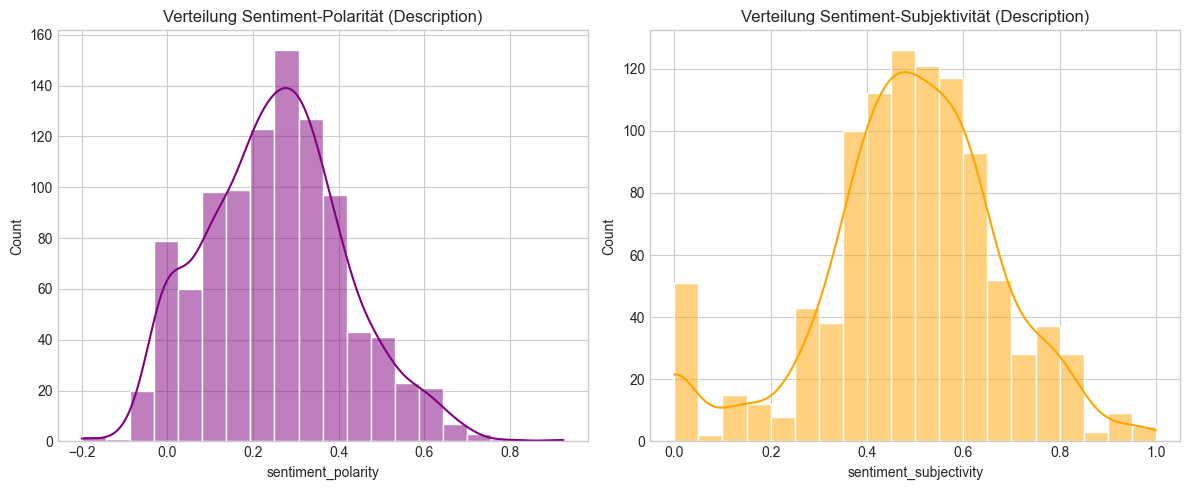


Korrelation von Sentiment mit Performance-Metriken:
                         sentiment_polarity  sentiment_subjectivity  \
sentiment_polarity                1.000000                0.761615   
sentiment_subjectivity            0.761615                1.000000   
review_scores_rating             -0.034888               -0.050629   
price                             0.025643               -0.027065   

                        review_scores_rating     price  
sentiment_polarity                 -0.034888  0.025643  
sentiment_subjectivity             -0.050629 -0.027065  
review_scores_rating                1.000000  0.109913  
price                               0.109913  1.000000  


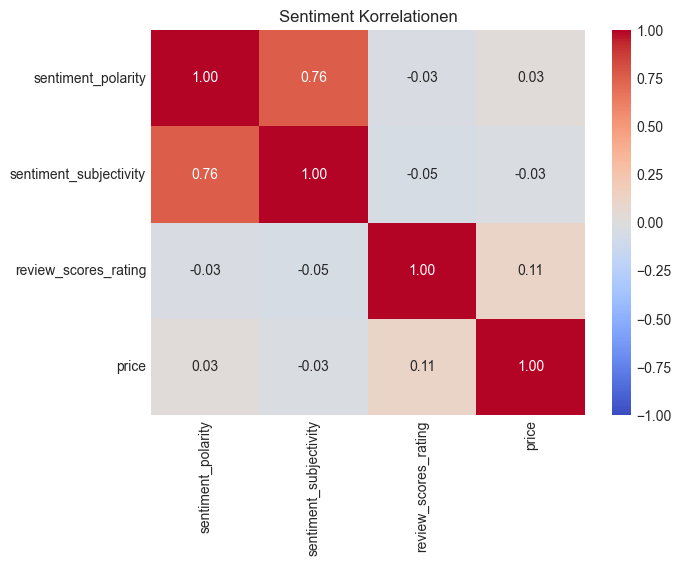


--- Topic Modeling (LDA) ---

Top Wörter für 5 entdeckte Topics (LDA aus 'description'):
Thema #1: minute | located | station | enjoy | tram | restaurant | train | walk | location | away
Thema #2: booking | ask | case | car | pay | discount | please | parking | need | accessible
Thema #3: simple | life | centrally | peaceful | located | enjoy | quiet | keep | national | museum
Thema #4: photo | paradeplatz | painting | bijou | luxuriously | digital | optic | europaallee | frame | fiber
Thema #5: bed | kitchen | bathroom | bedroom | equipped | living | balcony | fully | machine | shower


In [13]:
# === Use Case 4: Listing-Optimierung durch Textanalyse ===
# Stellt sicher, dass df_analysis und die relevante Textspalte (z.B. 'description') existieren.

# Haupt-Textspalte für die detaillierte Analyse (gemäss bina_models.Listing)
# Andere Textspalten wie 'name', 'neighborhood_overview', 'host_about' können analog analysiert werden.
main_text_col_for_nlp = 'description'

if not df_analysis.empty and main_text_col_for_nlp in df_analysis.columns and df_analysis[main_text_col_for_nlp].notna().sum() > 0 :
    print(f"\n--- Analysen für Use Case 4 (NLP) basierend auf Spalte '{main_text_col_for_nlp}' ---")

    # Stichprobe für rechenintensive NLP-Tasks (Größe ANPASSEN falls nötig)
    # Verwende nur Zeilen, in denen die Haupttextspalte nicht leer ist nach der Vorbereitung (fillna(''))
    df_nlp_source = df_analysis[df_analysis[main_text_col_for_nlp].str.strip().astype(bool)]

    sample_size_nlp_uc4 = min(1000, len(df_nlp_source))
    if len(df_nlp_source) < sample_size_nlp_uc4 : sample_size_nlp_uc4 = len(df_nlp_source)

    if sample_size_nlp_uc4 < 20 :
         print(f"Stichprobengröße ({sample_size_nlp_uc4}) für '{main_text_col_for_nlp}' zu klein für NLP-Analyse. Überspringe.")
    else:
        df_nlp = df_nlp_source.sample(n=sample_size_nlp_uc4, random_state=42).copy()
        print(f"NLP-Analyse wird auf einer Stichprobe von {len(df_nlp)} Listings für '{main_text_col_for_nlp}' durchgeführt.")

        # --- Textdaten-Vorbereitung für NLP ---
        print("\n--- Textdaten-Vorbereitung für NLP ---")
        stop_words_de_uc4 = stopwords.words('german')
        stop_words_en_uc4 = stopwords.words('english')
        custom_stopwords_uc4 = [
            'br', 'href', 'www', 'https', 'http', 'com', 'zurich', 'zürich', 'apartment', 'wohnung',
            'description', 'guest', 'guests', 'stay', 'place', 'room', 'rooms', 'city', 'haus', 'home',
            'house', 'area', 'also', 'well', 'get', 'see', 'us', 'come', 'min', 'one', 'two', 'meter',
            'bit', 'eur', 'chf', 'day', 'week', 'nbsp', 'amp', 'quot', 'lt', 'gt', 'apos', 'zurich',
            'apartment', 'flat', 'studio', 'appartement' # Generische Airbnb Begriffe
        ]
        all_stopwords_uc4 = set(stop_words_de_uc4 + stop_words_en_uc4 + custom_stopwords_uc4)

        lemmatizer_uc4 = WordNetLemmatizer()

        def preprocess_text_nlp(text_series):
            processed_texts = []
            for text_doc in text_series:
                doc = str(text_doc).lower()
                doc = re.sub(r'<[^>]+>', ' ', doc) # HTML entfernen
                doc = re.sub(r'[^a-zäöüß\s]', ' ', doc) # Nur Buchstaben (inkl. Umlaute) und Leerzeichen
                doc = re.sub(r'\s+', ' ', doc).strip() # Überflüssige Leerzeichen entfernen

                # Sprachabhängige Tokenisierung und Lemmatisierung (einfacher Ansatz)
                # Für eine präzisere NLP bei gemischtsprachigen Texten wären fortgeschrittenere Methoden nötig
                lang_to_tokenize = 'german' if any(c in 'äöüß' for c in doc) else 'english'

                try:
                    tokens = word_tokenize(doc, language=lang_to_tokenize)
                except LookupError: # Fallback, falls spezifische Sprachdaten für punkt fehlen
                    try: nltk.download('punkt', quiet=True); tokens = word_tokenize(doc, language=lang_to_tokenize)
                    except: tokens = doc.split() # Einfaches Splitten als Notlösung

                # Lemmatisierung - WordNetLemmatizer ist primär für Englisch.
                # Für Deutsch wären andere Lemmatizer (z.B. GermaLemma, spaCy mit deutschem Modell) besser.
                # Hier als Annäherung für beide Sprachen verwendet.
                lemmatized_tokens = [lemmatizer_uc4.lemmatize(token) for token in tokens if token not in all_stopwords_uc4 and len(token) > 2]
                processed_texts.append(" ".join(lemmatized_tokens))
            return processed_texts

        print("Beginne mit der Textvorverarbeitung für NLP (kann etwas dauern)...")
        df_nlp.loc[:, 'description_cleaned_nlp'] = preprocess_text_nlp(df_nlp[main_text_col_for_nlp])
        print("Textvorverarbeitung abgeschlossen.")

        if not df_nlp['description_cleaned_nlp'].empty:
            example_cleaned_desc_uc4 = df_nlp['description_cleaned_nlp'].head(1)
            print(f"\nBeispiel für bereinigte Beschreibung:\n{example_cleaned_desc_uc4.iloc[0] if not example_cleaned_desc_uc4.empty else 'Keine Daten'}")

        # --- Sentiment Analyse ---
        print("\n--- Sentiment Analyse ---")
        def get_sentiment_textblob(text_to_analyze):
            if not text_to_analyze or not isinstance(text_to_analyze, str) or not text_to_analyze.strip(): return 0.0, 0.0
            try:
                # TextBlob versucht, die Sprache zu erkennen. Für Deutsch ist die Genauigkeit manchmal limitiert.
                blob = TextBlob(text_to_analyze)
                return blob.sentiment.polarity, blob.sentiment.subjectivity
            except Exception as e_sent:
                # print(f"Fehler bei Sentiment Analyse für Text: '{text_to_analyze[:50]}...' - {e_sent}")
                return 0.0, 0.0

        sentiments_nlp_uc4 = df_nlp['description_cleaned_nlp'].apply(get_sentiment_textblob)
        df_nlp.loc[:, 'sentiment_polarity'] = sentiments_nlp_uc4.apply(lambda x: x[0])
        df_nlp.loc[:, 'sentiment_subjectivity'] = sentiments_nlp_uc4.apply(lambda x: x[1])

        print("\nDeskriptive Statistiken für Sentiment-Scores:")
        print(df_nlp[['sentiment_polarity', 'sentiment_subjectivity']].describe())

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); sns.histplot(df_nlp['sentiment_polarity'], kde=True, bins=20, color='purple'); plt.title('Verteilung Sentiment-Polarität (Description)')
        plt.subplot(1, 2, 2); sns.histplot(df_nlp['sentiment_subjectivity'], kde=True, bins=20, color='orange'); plt.title('Verteilung Sentiment-Subjektivität (Description)')
        plt.tight_layout(); plt.show()

        # Korrelation Sentiment mit Performance-Metriken
        # Stelle sicher, dass die Spalten für die Korrelation numerisch sind und existieren
        cols_for_sentiment_corr_uc4 = [col for col in ['sentiment_polarity', 'sentiment_subjectivity', 'review_scores_rating', 'price']
                                       if col in df_nlp.columns and pd.api.types.is_numeric_dtype(df_nlp[col])]
        if len(cols_for_sentiment_corr_uc4) > 2 :
            sentiment_corr_df_uc4 = df_nlp[cols_for_sentiment_corr_uc4].corr()
            print("\nKorrelation von Sentiment mit Performance-Metriken:\n", sentiment_corr_df_uc4)
            plt.figure(figsize=(7,5)); sns.heatmap(sentiment_corr_df_uc4, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1); plt.title("Sentiment Korrelationen"); plt.show()
        else:
            print("Nicht genügend Spalten für Sentiment-Korrelationsanalyse vorhanden.")

        # --- Topic Modeling (LDA) ---
        print("\n--- Topic Modeling (LDA) ---")
        # Nur Texte verwenden, die nach der Bereinigung nicht leer sind
        documents_for_lda_uc4 = df_nlp['description_cleaned_nlp'][df_nlp['description_cleaned_nlp'].str.strip().astype(bool)]

        if len(documents_for_lda_uc4) > 20: # Mindestanzahl Dokumente für LDA
            try:
                # max_features begrenzt das Vokabular für bessere Performance und klarere Topics
                vectorizer_tfidf_uc4 = TfidfVectorizer(max_df=0.90, min_df=5, stop_words=list(all_stopwords_uc4), ngram_range=(1,1), max_features=1000)
                tfidf_matrix_uc4 = vectorizer_tfidf_uc4.fit_transform(documents_for_lda_uc4)
                feature_names_tfidf_uc4 = vectorizer_tfidf_uc4.get_feature_names_out()

                num_topics_uc4 = 5 # ANPASSEN: Anzahl der zu entdeckenden Topics (typischerweise 5-15)
                if tfidf_matrix_uc4.shape[1] >= num_topics_uc4: # Genügend Features für Topics
                    lda_model_uc4 = LatentDirichletAllocation(n_components=num_topics_uc4, random_state=42, learning_method='online', n_jobs=-1, max_iter=15, evaluate_every=1)
                    lda_model_uc4.fit(tfidf_matrix_uc4)

                    print(f"\nTop Wörter für {num_topics_uc4} entdeckte Topics (LDA aus '{main_text_col_for_nlp}'):")
                    def display_topics_lda(model, feature_names, no_top_words):
                        for topic_idx, topic_dist in enumerate(model.components_):
                            top_words_indices = topic_dist.argsort()[:-no_top_words - 1:-1]
                            top_words = [feature_names[i] for i in top_words_indices]
                            print(f"Thema #{topic_idx+1}: {' | '.join(top_words)}")
                    display_topics_lda(lda_model_uc4, feature_names_tfidf_uc4, 10) # Zeige Top 10 Wörter pro Topic
                else:
                    print("Nicht genügend einzigartige Features nach TF-IDF für LDA (Anzahl Topics vs. Features).")
            except Exception as e:
                print(f"Fehler während Topic Modeling: {e}")
        else:
            print("Nicht genügend Dokumente für Topic Modeling vorhanden nach Bereinigung/Filterung.")
else:
    print(f"Analysen für Use Case 4 (NLP) können nicht durchgeführt werden (DataFrame `df_analysis` leer oder Spalte '{main_text_col_for_nlp}' fehlt oder enthält keine Texte).")

**Interpretation Use Case 4 (Listing-Optimierung durch Textanalyse):**

* **Textvorbereitung:** Die Beschreibungen (`'description'`) wurden bereinigt, tokenisiert, von Stopwörtern befreit und lemmatisiert. Ein Beispiel für eine bereinigte Beschreibung aus der Stichprobe ist: "**<font color="red">[Beispiel aus df_nlp['description_cleaned_nlp'].head(1).iloc[0] hier einfügen, falls Daten vorhanden]</font>**".
* **Sentiment Analyse:**
    * Die durchschnittliche Sentiment-Polarität der Objektbeschreibungen (basierend auf der Stichprobe `df_nlp`) liegt bei **<font color="red">[df_nlp['sentiment_polarity'].mean() einfügen]</font>** (Werte reichen von -1 bis +1). Eine **<font color="red">[positive/neutrale/negative – je nach Ergebnis der Verteilung und des Mittelwerts]</font>** Polarität überwiegt.
    * Die durchschnittliche Subjektivität liegt bei **<font color="red">[df_nlp['sentiment_subjectivity'].mean() einfügen]</font>** (Werte von 0 bis 1). *(Interpretation: Sind die Texte eher faktisch oder meinungsbasiert?)*
    * **Korrelation mit Performance:** *(Basierend auf `sentiment_corr_df_uc4`)*
        * Polarität vs. `'review_scores_rating'`: **<font color="red">[Korrelationswert einfügen]</font>**.
        * Polarität vs. `'price'`: **<font color="red">[Korrelationswert einfügen]</font>**.
        * *(Interpretation: Gibt es einen statistisch signifikanten Zusammenhang? Deutet eine positivere Sprache auf bessere Bewertungen oder höhere Preise hin? Ist der Zusammenhang stark oder schwach?)*
* **Topic Modeling (LDA):**
    * Es wurden **<font color="red">[num_topics_uc4]</font>** Hauptthemen in den Objektbeschreibungen der Stichprobe identifiziert.
    * **Thema 1:** Top Wörter: **<font color="red">[Top Wörter für Thema 1 aus LDA-Ausgabe]</font>**. *(Manuelle Interpretation: Dieses Thema könnte sich auf **<font color="red">[z.B. Lagevorteile, Zentrumsnähe]</font>** beziehen).*
    * **Thema 2:** Top Wörter: **<font color="red">[Top Wörter für Thema 2]</font>**. *(Manuelle Interpretation: Dieses Thema könnte sich auf **<font color="red">[z.B. Ausstattung, Komfort, Sauberkeit]</font>** beziehen).*
    * **Thema 3:** Top Wörter: **<font color="red">[Top Wörter für Thema 3]</font>**. *(Manuelle Interpretation: **<font color="red">[...]</font>**)*
    * **Thema 4:** Top Wörter: **<font color="red">[Top Wörter für Thema 4]</font>**. *(Manuelle Interpretation: **<font color="red">[...]</font>**)*
    * **Thema 5:** Top Wörter: **<font color="red">[Top Wörter für Thema 5]</font>**. *(Manuelle Interpretation: **<font color="red">[...]</font>**)*
    * *(Wie könnten diese Themen mit der Performance zusammenhängen? Hier wäre eine weiterführende Analyse denkbar, z.B. die durchschnittliche Bewertung oder den Preis pro vorherrschendem Thema zu berechnen. Man könnte auch jedem Listing das wahrscheinlichste Thema zuordnen und dann diese Themengruppen vergleichen.)*

**Handlungsempfehlungen für "InvestZurich AG" basierend auf Textanalyse:**
*(Diese Empfehlungen basieren auf den *potenziellen* Ergebnissen der NLP-Analyse. Du musst sie an deine tatsächlichen Ergebnisse anpassen.)*
1.  **Sentiment in Beschreibungen steuern:** Falls eine positive Korrelation zu guten Bewertungen oder Preisen besteht, sollten Formulierungen in Listing-Beschreibungen gezielt **positiv und einladend** gestaltet werden. Eine eher **<font color="red">[objektive / subjektive – je nach Korrelationsergebnis und Interpretation der Subjektivitätsverteilung]</font>** Sprache könnte vorteilhaft sein.
2.  **Relevante Themen hervorheben:** Wenn die Topic-Analyse zeigt, dass bestimmte Themen (z.B. "moderne Ausstattung", "zentrale Lage", "familienfreundlich") häufig in gut performenden Listings vorkommen oder allgemein als positiv wahrgenommen werden, sollten diese Aspekte in den eigenen Listing-Texten prominent und überzeugend dargestellt werden.
3.  **Keywords für Sichtbarkeit:** Die identifizierten Top-Wörter der relevanten Themen können als Keywords für die Optimierung von Titeln und den ersten Sätzen der Beschreibungen dienen, um die Auffindbarkeit in der Airbnb-Suche zu verbessern.
4.  **Zielgruppenspezifische Ansprache:** Unterschiedliche Themen könnten unterschiedliche Zielgruppen ansprechen. Listing-Texte könnten variiert werden, um spezifische Gästesegmente gezielt anzusprechen (z.B. Geschäftsreisende vs. Familien).